# Asteroid Hazard Prediction using Machine Learning

## Table of Contents

1.  [Introduction](#introduction)
2.  [Data Loading](#data-loading)
3.  [Data Exploration and Preprocessing](#data-exploration-and-preprocessing)
4.  [XGBoost Analysis for Feature Reduction](#xgboost-analysis-for-feature-reduction)
5.  [Model Building and Handling Class Imbalance](#model-building-and-handling-class-imbalance)
    *   [SMOTE Oversampling](#smote-oversampling)
        - [Random Forest with SMOTE Oversampling](#random-forest-with-smote-oversampling)
        - [XGBoost with SMOTE Oversampling](#xgboost-with-smote-oversampling)
    *   [ADASYN Oversampling](#adasyn-oversampling)
        - [Random Forest with ADASYN Oversampling](#random-forest-with-adasyn-oversampling)
        - [XGBoost with ADASYN Oversampling](#xgboost-with-adasyn-oversampling)
    *   [NearMiss Undersampling](#nearmiss-undesampling)
        - [Random Forest with NearMiss Undersampling](#random-forest-with-nearmiss-undersampling)
        - [XGBoost with NearMiss Undersampling](#xgboost-with-nearmiss-undersampling)
    *   [SMOTE-ENN: Combined Oversampling and Undersampling](#smote-enn:-combined-oversampling-and-undersampling)
        - [Random Forest with SMOTE-ENN](#random-forest-with-smote-enn)
        - [XGBoost with SMOTE-ENN](#xgboost-with-smote-enn)
    *   [Class Weight Adjustment](#5-class-weight-adjustment)
        - [Random Forest with Adjusted Class Weights](#random-forest-with-adjusted-class-weights)
        - [XGBoost with Adjusted Class Weights](#xgboost-with-adjusted-class-weights)
6.  [XGBoost Hyperparameter Tuning](#xgboost-hyperparameter-tuning)
    *   [Learning Rate](#learning-rate)
    *   [Number of Estimators (n_estimators)](#number-of-estimators-n_estimators)
    *   [Minimum Child Weight (min_child_weight)](#minimum-child-weight-min_child_weight)
    *   [Maximum Depth (max_depth)](#maximum-depth-max_depth)
    *   [Gamma](#gamma)
7.  [Model Evaluation: Cross-Validation and Precision-Recall Analysis](#model-evaluation-cross-validation-and-precision-recall-analysis)
8.  [Conclusions](#conclusions)

## Introduction

This project aims to develop a machine learning model to predict whether an asteroid is potentially hazardous to Earth. Accurate prediction can aid in planetary defense efforts.

### Problem Definition

The goal is to develop a classification model that can accurately identify potentially hazardous asteroids (PHAs) based on their physical and orbital characteristics.

### Dataset

I will be using the NASA Near-Earth Object (NEO) dataset available on Kaggle: [NASA Near-Earth Objects](https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects). 
This dataset contains information on asteroid parameters such as diameter, relative velocity, miss distance, and absolute magnitude.

### Objectives

*   Explore the NEO dataset and understand its characteristics.
*   Preprocess the data and handle missing values (if any).
*   Engineer new features that may improve model performance.
*   Build a classification model to predict whether an asteroid is hazardous.
*   Evaluate the model using appropriate metrics and interpret the results.

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, precision_recall_curve, precision_score, recall_score, average_precision_score
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTEENN
from collections import Counter
from sklearn.utils import compute_sample_weight

## Data Loading

In [111]:
# Load the data from the CSV file
raw_data = pd.read_csv("neo_v2.csv")

## Data Exploration and Preprocessing

In [112]:
# Display the first few rows of the dataframe to understand the structure of the data
raw_data.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [113]:
# Summary of data types and missing values in each column
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


In [114]:
raw_data['orbiting_body'].nunique()

1

In [115]:
raw_data['sentry_object'].nunique()

1

Features "orbiting_body" and "sentry_object" have only one single value.

In [116]:
# Remove features having only a single unique value
data = raw_data.drop(['orbiting_body','sentry_object'], axis=1)
data

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,20.09,True
...,...,...,...,...,...,...,...,...
90831,3763337,(2016 VX1),0.026580,0.059435,52078.886692,1.230039e+07,25.00,False
90832,3837603,(2019 AD3),0.016771,0.037501,46114.605073,5.432121e+07,26.00,False
90833,54017201,(2020 JP3),0.031956,0.071456,7566.807732,2.840077e+07,24.60,False
90834,54115824,(2021 CN5),0.007321,0.016370,69199.154484,6.869206e+07,27.80,False


In [117]:
# Check for missing values
data.isnull().sum()

id                    0
name                  0
est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
absolute_magnitude    0
hazardous             0
dtype: int64

In [118]:
# Check for duplicated rows
data.duplicated().sum()

0

In [119]:
# Get the number of rows in the DataFrame
total_count = len(data)
total_count 

90836

In [120]:
# Count occurrences of hazardous = True (since True is treated as 1 and False as 0)
hazardous_count = data['hazardous'].sum()
hazardous_count

8840

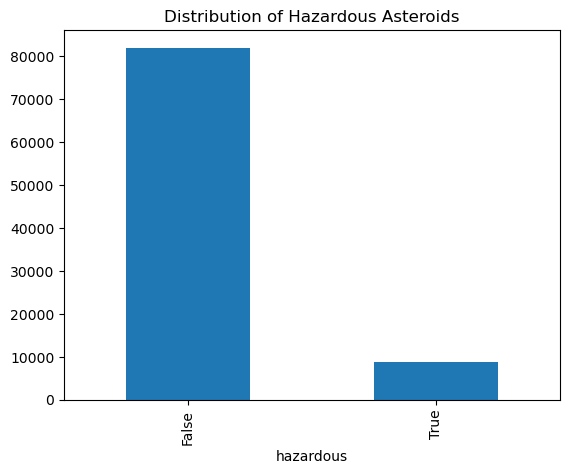

In [121]:
# Visualizing the distribution of the 'hazardous' variable
data.hazardous.value_counts().plot(kind='bar')
plt.title('Distribution of Hazardous Asteroids')
plt.show()

The plot shows a significant class imbalance, with far fewer hazardous asteroids than non-hazardous ones.

In [122]:
# Count unique values in "name" column
unique_count = data['name'].nunique()
unique_count

27423

In [123]:
# Count unique values in "name" column, where 'hazardous' is True
unique_hazardous_count = data[data['hazardous'] == True]['name'].nunique()
unique_hazardous_count

2173

In [124]:
data[data['hazardous'] == True]['name'].value_counts()

name
138175 (2000 EE104)    39
468910 (2014 KQ76)     35
418849 (2008 WM64)     34
85990 (1999 JV6)       33
164202 (2004 EW)       27
                       ..
(2016 UF101)            1
(2016 TZ17)             1
(2016 WG9)              1
(2003 GP51)             1
(2022 GJ3)              1
Name: count, Length: 2173, dtype: int64

The output shows how many times each hazardous asteroid appears in the dataset. For example, the asteroid named "138175 (2000 EE104)" is classified as hazardous and appears 39 times in the dataset. 

In [125]:
# Calculate the values
total_count = len(data)
hazardous_count = data['hazardous'].sum()
unique_count = data['name'].nunique()
unique_hazardous_count = data[raw_data['hazardous'] == True]['name'].nunique()

# Calculate percentages
hazardous_percentage = round((hazardous_count / total_count) * 100,1)
unique_hazardous_percentage = round((unique_hazardous_count / unique_count) * 100,1) if unique_count > 0 else 0

# Create a new DataFrame with the results
results_df = pd.DataFrame({
    'Total Count': [total_count],
    'Hazardous Count': [hazardous_count],
    'Unique Count': [unique_count],
    'Unique Hazardous Count': [unique_hazardous_count],
    'Hazardous Percentage': [hazardous_percentage],
    'Unique Hazardous Percentage': [unique_hazardous_percentage]
})
results_df

,Total Count,Hazardous Count,Unique Count,Unique Hazardous Count,Hazardous Percentage,Unique Hazardous Percentage
0,90836,8840,27423,2173,9.7,7.9


Multiple entries per asteroid explain why hazardous percentage (9.7%) is higher than unique hazardous percentage (7.9%).

In [126]:
data[data['name'] == "164202 (2004 EW)"]

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
463,2164202,164202 (2004 EW),0.183889,0.411188,65650.421766,4.867488e+07,20.8,True
3392,2164202,164202 (2004 EW),0.183889,0.411188,54879.660984,3.408699e+07,20.8,True
6372,2164202,164202 (2004 EW),0.183889,0.411188,44190.593061,1.962871e+07,20.8,True
9320,2164202,164202 (2004 EW),0.183889,0.411188,33941.264708,6.172050e+06,20.8,True
12493,2164202,164202 (2004 EW),0.183889,0.411188,25135.246425,8.853940e+06,20.8,True
16020,2164202,164202 (2004 EW),0.183889,0.411188,20591.583096,2.114512e+07,20.8,True
18691,2164202,164202 (2004 EW),0.183889,0.411188,24447.455450,3.420558e+07,20.8,True
19552,2164202,164202 (2004 EW),0.183889,0.411188,23063.648860,3.046189e+07,20.8,True
21992,2164202,164202 (2004 EW),0.183889,0.411188,31102.745147,3.924934e+07,20.8,True
23305,2164202,164202 (2004 EW),0.183889,0.411188,25033.900195,3.621064e+07,20.8,True



The table above shows examples of asteroids with duplicate entries in the dataset. Notice that while the 'name' is the same for these entries, the 'relative_velocity' and 'miss_distance' values are different.

This indicates that these asteroids were observed multiple times, and their velocity and distance from Earth were recalculated with each observation. These values change as the asteroid moves along its orbit. The differences in velocity and distance reflect the changing positions of the asteroid and Earth at the time of each observation.


There is a significant imbalance in the proportions of the hazardous classes, with approximately 90% classified as False (non-hazardous) and 10% as True (hazardous). Therefore, I have decided to process the data in a non-standard way: I will remove duplicated asteroids from the majority class (non-hazardous) while retaining duplicated asteroids from the minority class (hazardous), because those are the same potentially dangerous asteroid observed in different circumstances, whereas duplicates in majority class are redunandant. 

In [127]:
# Keep duplicates from the minority class (hazardous)
hazardous_asteroids = data[data['hazardous'] == True]

# Drop duplicates from the majority class (non-hazardous)
non_hazardous_asteroids = data[data['hazardous'] == False].drop_duplicates(subset='name')

# Combine the two DataFrames
filtered_data = pd.concat([hazardous_asteroids, non_hazardous_asteroids])

# Reset index if needed
filtered_data.reset_index(drop=True, inplace=True)

filtered_data

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,20.00,True
1,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,20.09,True
2,54049873,(2020 OT6),0.252671,0.564989,58430.697200,3.833750e+07,20.11,True
3,2506491,506491 (2003 UW29),0.201630,0.450858,115899.180498,1.510102e+07,20.60,True
4,3781344,(2017 RV),0.110804,0.247765,48655.305132,3.279775e+07,21.90,True
...,...,...,...,...,...,...,...,...
34085,3779523,(2017 OL68),0.176423,0.394494,4649.668900,4.064435e+07,20.89,False
34086,54272756,(2022 GA4),0.232571,0.520044,34153.422552,3.376447e+07,20.29,False
34087,54225015,(2021 WR3),0.310853,0.695088,103342.744852,6.254685e+07,19.66,False
34088,3735178,(2015 VK142),0.350393,0.783502,65388.349843,6.344693e+07,19.40,False


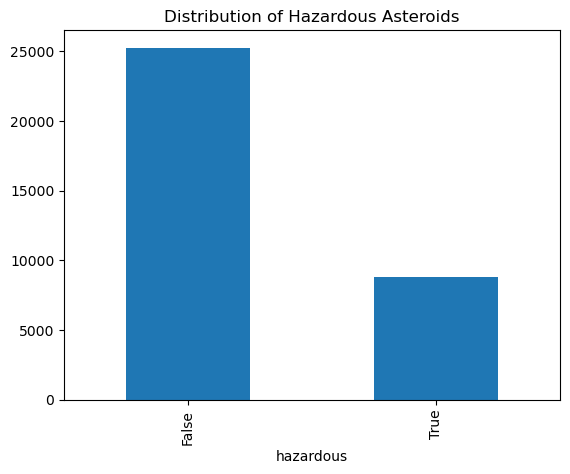

In [128]:
# plot distribution of hazardous asteroids
filtered_data.hazardous.value_counts().plot(kind='bar')
plt.title('Distribution of Hazardous Asteroids')
plt.show()

In [129]:
total_count = len(filtered_data)
hazardous_count = filtered_data['hazardous'].sum()

# Calculate percentage
hazardous_percentage = round((hazardous_count / total_count) * 100,1)
hazardous_percentage

25.9

The selective dropping of duplicates based on class proportions, where duplicates from the majority class (non-hazardous) were removed while those from the minority class (hazardous) were retained, led to an improvement in the class balance. As a result, the proportion of hazardous asteroids increased to nearly 26% of the total dataset. However, the dataset remains highly imbalanced, making further class-balancing techniques, such as undersampling or oversampling, necessary.

In [130]:
filtered_data.columns

Index(['id', 'name', 'est_diameter_min', 'est_diameter_max',
       'relative_velocity', 'miss_distance', 'absolute_magnitude',
       'hazardous'],
      dtype='object')

In [131]:
# Descriptive statistics for numerical features to understand the distribution of the data
features = ['est_diameter_min', 'est_diameter_max',
       'relative_velocity', 'miss_distance', 'absolute_magnitude']

filtered_data[features].describe()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,34090.000000,34090.000000,34090.000000,3.409000e+04,34090.000000
mean,0.168036,0.375739,51619.391589,3.466970e+07,22.771270
std,0.363422,0.812637,26763.779739,2.324291e+07,2.898157
min,0.000609,0.001362,561.695602,9.316925e+03,9.230000
25%,0.026580,0.059435,30964.107753,1.224904e+07,20.600000
50%,0.084053,0.187949,47745.784298,3.414630e+07,22.500000
75%,0.201630,0.450858,67375.140677,5.544351e+07,25.000000
max,37.892650,84.730541,236990.128088,7.479865e+07,33.200000


Key observations:
- Most asteroids are relatively small, , but some outliers are very large (~85 km in diameter).
- Asteroid velocities vary widely, with some moving extremely fast (~237 000 km/h).
- Most asteroids pass Earth at a safe distance, but some come very close (~9 317 km), posing a potential hazard.
- The dataset contains a mix of bright and faint asteroids, with absolute magnitude indicating significant variability in size and reflectivity.

In [132]:
filtered_data = filtered_data.drop(['id', 'name'], axis=1)

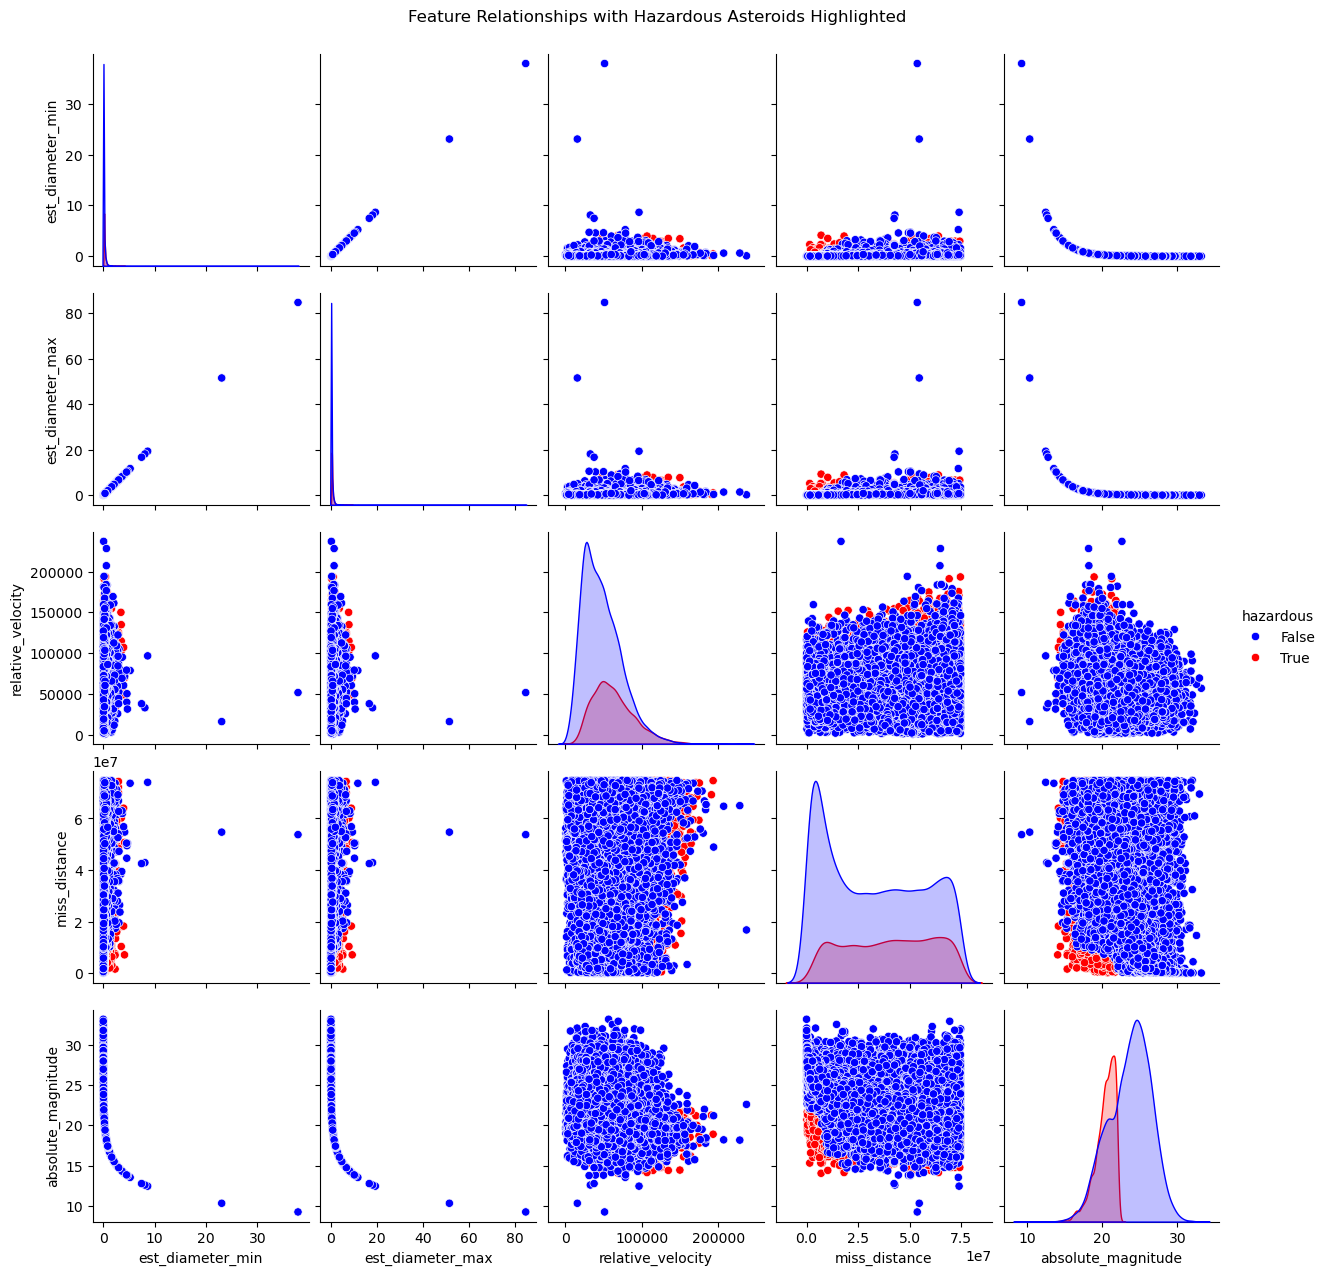

In [133]:
# Generate a pair plot to visualize relationships between all numerical features, colored by the 'hazardous' status
custom_palette = {False: "blue", True: "red"} # Define custom colors for the 'hazardous' variable
sns.pairplot(filtered_data,hue="hazardous", palette=custom_palette)
plt.suptitle("Feature Relationships with Hazardous Asteroids Highlighted", y=1.02)
plt.show()

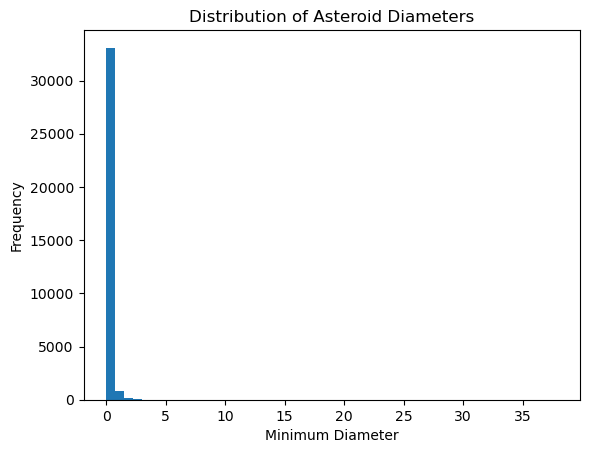

In [134]:
# Histogram of asteroid diameters
plt.hist(filtered_data['est_diameter_min'], bins=50)
plt.title('Distribution of Asteroid Diameters')
plt.xlabel('Minimum Diameter')
plt.ylabel('Frequency')
plt.show()

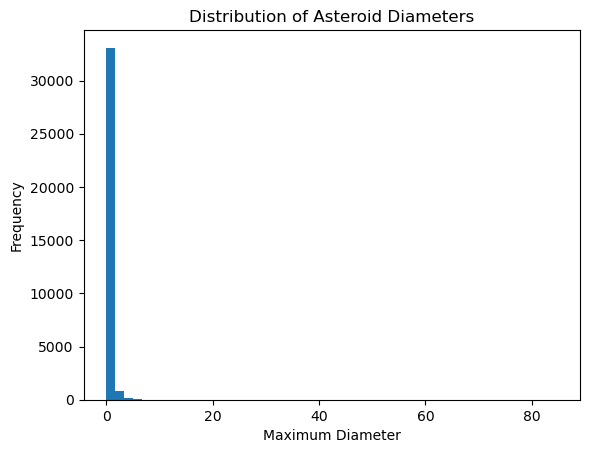

In [135]:
# Histogram of asteroid diameters
plt.hist(filtered_data['est_diameter_max'], bins=50)
plt.title('Distribution of Asteroid Diameters')
plt.xlabel('Maximum Diameter')
plt.ylabel('Frequency')
plt.show()

The distribution of asteroid diameters is highly skewed to the right, indicating that most asteroids are relatively small.

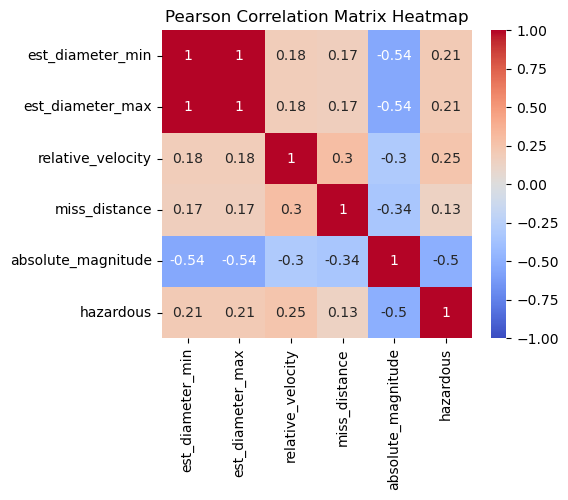

In [136]:
# Calculate the correlation matrix
correlation_matrix = filtered_data.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Pearson Correlation Matrix Heatmap')
plt.show()

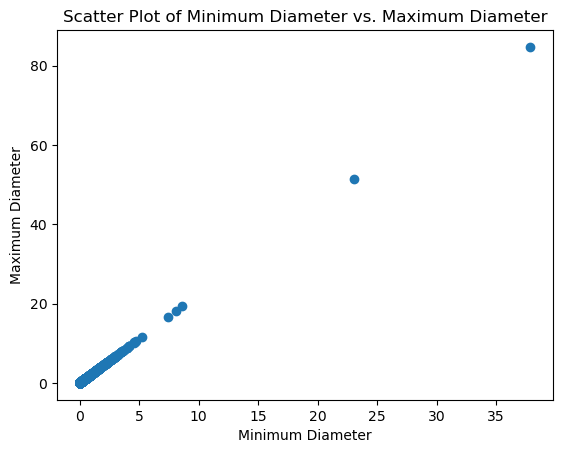

In [137]:
# Scatter plot of absolute magnitude vs. diameter
plt.scatter(filtered_data['est_diameter_min'], filtered_data['est_diameter_max'])
plt.title('Scatter Plot of Minimum Diameter vs. Maximum Diameter')
plt.xlabel('Minimum Diameter')
plt.ylabel('Maximum Diameter')
plt.show()

The plot reveals an exact proportional relationship between the estimated minimum (est_diameter_min) and maximum (est_diameter_max) diameters.

When two parameters, such as the minimal and maximal diameters of asteroids, are perfectly correlated (with a correlation value of 1), it indicates redundancy in the features. This can pose challenges when building predictive models, as it may lead to overfitting and complicate model interpretation. To address this issue I will combine these features
into a new one: Instead of using both diameters separately, I will create an average diameter: 
Average Diameter=
(Min Diameter+Max Diameter)/2
​


In [138]:
# Calculate the Average Diameter
average_diameter = (filtered_data['est_diameter_min'] + filtered_data['est_diameter_max']) / 2

# Insert the Average Diameter column at the first position (index 0)
filtered_data.insert(0, 'average_diameter', average_diameter)

# Drop the original diameter columns
filtered_data.drop(['est_diameter_min', 'est_diameter_max'], axis=1, inplace=True)
filtered_data

,average_diameter,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,0.430073,73588.726663,6.143813e+07,20.00,True
1,0.412613,42737.733765,4.627557e+07,20.09,True
2,0.408830,58430.697200,3.833750e+07,20.11,True
3,0.326244,115899.180498,1.510102e+07,20.60,True
4,0.179284,48655.305132,3.279775e+07,21.90,True
...,...,...,...,...,...
34085,0.285458,4649.668900,4.064435e+07,20.89,False
34086,0.376307,34153.422552,3.376447e+07,20.29,False
34087,0.502971,103342.744852,6.254685e+07,19.66,False
34088,0.566947,65388.349843,6.344693e+07,19.40,False


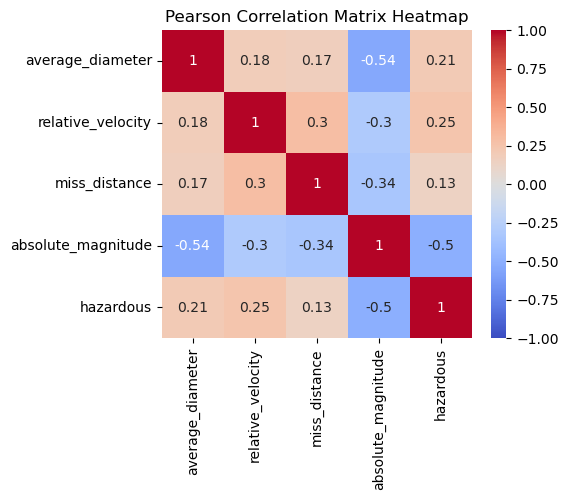

In [139]:
# Calculate the correlation matrix
correlation_matrix = filtered_data.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Pearson Correlation Matrix Heatmap')
plt.show()

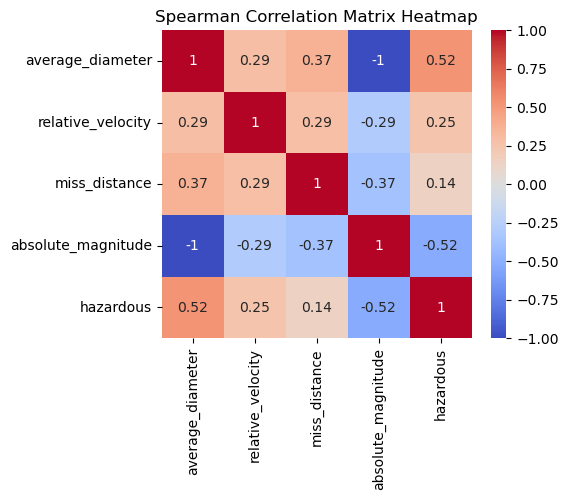

In [140]:
# Calculate the correlation matrix
correlation_matrix = filtered_data.corr(method='spearman')

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Spearman Correlation Matrix Heatmap')
plt.show()

              Feature  Correlation
0    average_diameter     0.524184
1   relative_velocity     0.251498
2       miss_distance     0.142038
3  absolute_magnitude    -0.524184


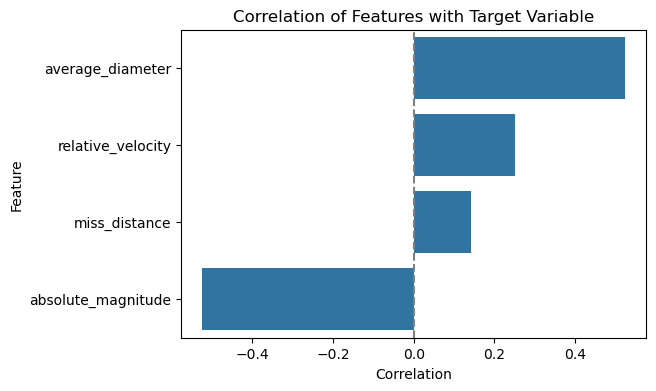

In [141]:
# Calculate correlation with the target variable
target_correlation = filtered_data.corrwith(filtered_data['hazardous'], method = 'spearman')

# Convert to DataFrame for better visualization
target_correlation_df = target_correlation.reset_index()
target_correlation_df.columns = ['Feature', 'Correlation']

# Exclude the correlation of the target with itself
target_correlation_df = target_correlation_df[target_correlation_df['Feature'] != 'hazardous']

# Sort by correlation values
target_correlation_df = target_correlation_df.sort_values(by='Correlation', ascending=False)

# Display the correlation with the target variable
print(target_correlation_df)

# Visualize the correlations using a bar plot
plt.figure(figsize=(6, 4))
sns.barplot(x='Correlation', y='Feature', data=target_correlation_df)
plt.title('Correlation of Features with Target Variable')
plt.axvline(0, color='gray', linestyle='--')  # Add a vertical line at zero for reference
plt.show()

Spearman correlation results indicated two important points:
1. Absolute magnitude and average diameter of asteroids are correlated with the hazardous output to a similar extent (approximately 0.52). Absolute magnitude shows a negative correlation, while average diameter shows a positive correlation.
2. The Spearman correlation between absolute magnitude and average diameter is -1, indicating a very strong inverse relationship.

To further investigate this relationship, I will create a scatter plot to visualize the correlation between absolute magnitude and average diameter.

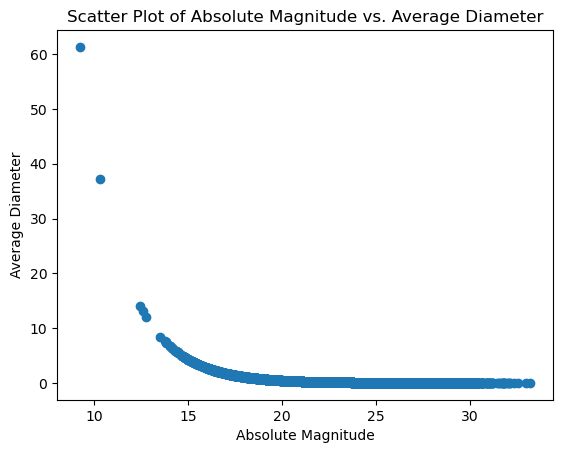

In [142]:
# Scatter plot of absolute magnitude vs. average diameter
plt.scatter(filtered_data['absolute_magnitude'], filtered_data['average_diameter'])
plt.title('Scatter Plot of Absolute Magnitude vs. Average Diameter')
plt.xlabel('Absolute Magnitude')
plt.ylabel('Average Diameter')
plt.show()

The scatter plot confirms a negative correlation between absolute magnitude and average diameter, which is in accordance with the fact that brighter asteroids tend to be larger.

### Understanding Absolute Magnitude

Absolute magnitude (H) measures how bright an asteroid would appear at a standard distance. Lower H means brighter.

Larger asteroids generally reflect more sunlight (are brighter), resulting in lower absolute magnitudes. However, composition and reflectivity (albedo) also influence brightness, so the relationship isn't perfect. 

The Equation for Diameter and Absolute Magnitude:

The relationship between the asteroid's diameter D (in kilometers), its absolute magnitude H, and its albedo p (reflectivity of the asteroid) is given by the equation:

$$ D = \frac{1329}{\sqrt{p}} \cdot 10^{-0.2 \cdot H} $$

Where:

*   D: Diameter of the asteroid (in kilometers)
*   H: Absolute magnitude of the asteroid
*   p: Albedo (a dimensionless number between 0 and 1 representing reflectivity)


This equation expresses how the diameter depends on both the absolute magnitude and the albedo.

A perfect negative Spearman correlation of −1 between diameter and absolute magnitude suggests that these features are redundant in predicting the target variable. Removing redundant features can improve model interpretability and potentially enhance performance. To determine which feature contributes less to the model's predictive ability, I will analyze feature importance and drop the less significant one.

## XGBoost Analysis for Feature Reduction

In [143]:
# Separate features and target variable
X = filtered_data.drop(['hazardous'], axis=1)  
y = filtered_data['hazardous']

To split a dataset while maintaining the proportion of hazardous and non-hazardous asteroids, I will use the stratify parameter in the train_test_split.

In [144]:
# Split data into training, validation, and test sets (70% train, 15% validation, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Check the distribution of classes in the training and testing sets
print("Training set class distribution:\n", round(y_train.value_counts(normalize=True),2))
print("Testing set class distribution:\n", round(y_test.value_counts(normalize=True),2))

Training set class distribution:
 hazardous
False    0.74
True     0.26
Name: proportion, dtype: float64
Testing set class distribution:
 hazardous
False    0.74
True     0.26
Name: proportion, dtype: float64


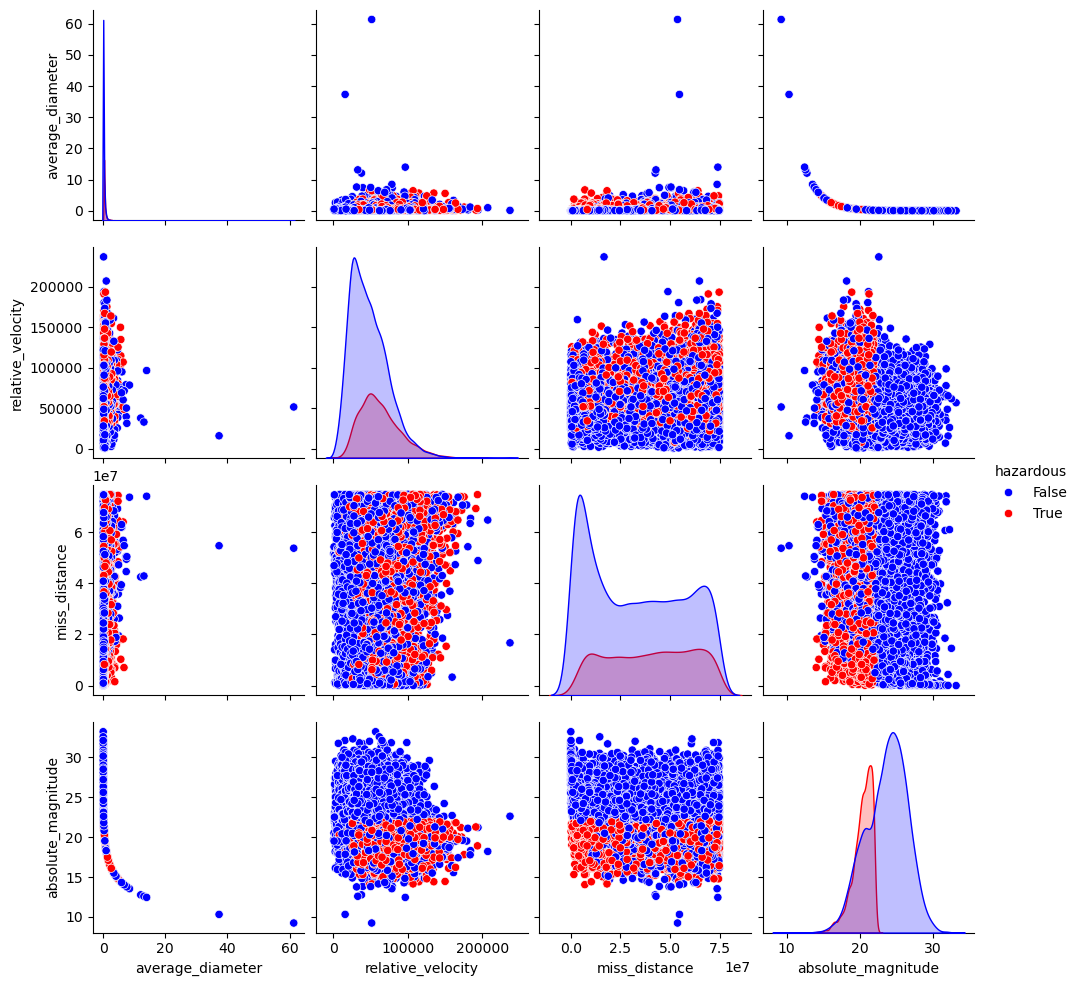

In [145]:
# Add target back to training and testing sets for visualization
train_df = X_train.copy()
train_df['hazardous'] = y_train

# Visualize the distribution using pairplot
sns.pairplot(train_df, hue='hazardous', palette=custom_palette)
plt.show()

              precision    recall  f1-score   support

       False       0.91      0.87      0.89      3787
        True       0.66      0.74      0.70      1326

    accuracy                           0.83      5113
   macro avg       0.78      0.80      0.79      5113
weighted avg       0.84      0.83      0.84      5113



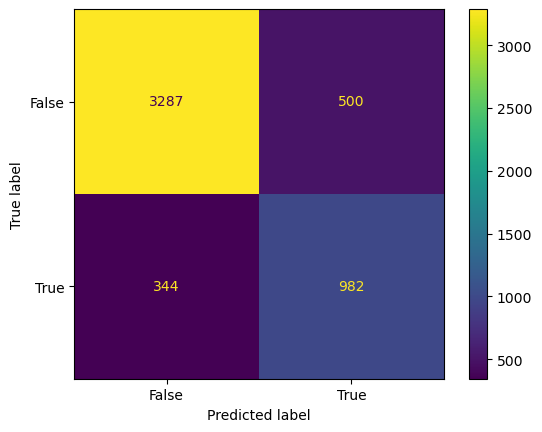

In [146]:
# Create an XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=1)

# Fit the model on the training data
xgb_classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = xgb_classifier.predict(X_val)

# Evaluate the model's performance
print(classification_report(y_val, y_pred))
ConfusionMatrixDisplay.from_predictions(y_val,y_pred)

I will compare feature importance in predicting hazardous asteroids using two different criteria: gain and weight:
- **Gain:** This measures how much a feature improves the model’s accuracy (or reduces error) when it is used in a split. A higher gain value means the feature has a stronger influence on the model’s predictions.
- **Weight:** This represents how often a feature is used in the decision trees. Unlike gain, weight does not measure a feature’s impact on accuracy—only how frequently it appears in the model’s decision-making process. A higher weight indicates that the feature is used more often in tree splits.

<Figure size 1000x600 with 0 Axes>

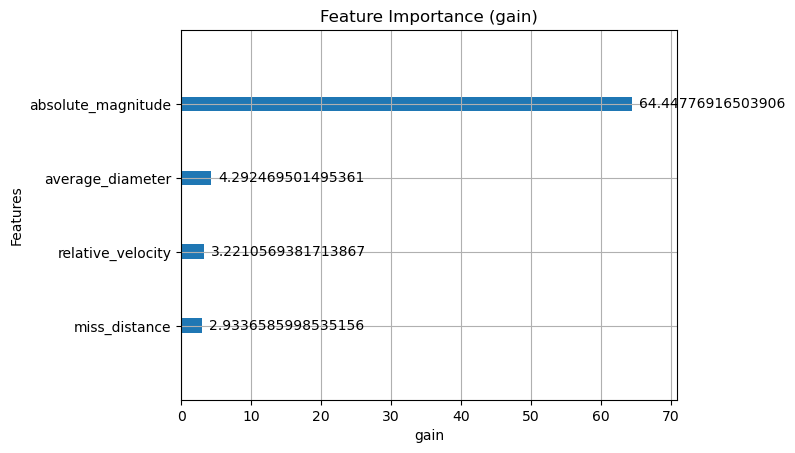

<Figure size 1000x600 with 0 Axes>

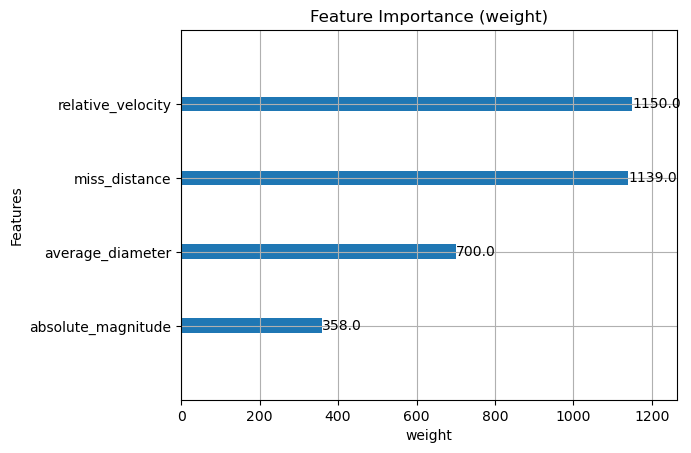

In [147]:
importance_types = ['gain', 'weight']

for imp_type in importance_types:
    plt.figure(figsize=(10, 6))
    xgb.plot_importance(xgb_classifier, importance_type=imp_type, title=f'Feature Importance ({imp_type})', xlabel=imp_type, ylabel='Features')
    plt.show()


These results suggest that:

- Absolute magnitude is very powerful when used, but it doesn’t appear in many splits. This is likely because it is strongly correlated with average diameter, making it somewhat redundant. This aligns with my previous correlation analysis of these two features.
- Relative velocity and miss distance frequently appear in tree splits, meaning they are often used in decision-making, but they may not always provide the strongest accuracy improvement.

Based on these findings, I will drop average diameter, as it is redundant to absolute magnitude. To ensure this simplification does not negatively impact the model, I will compare its performance metrics before and after removing average diameter.

In [148]:
X_train = X_train.drop(columns=['average_diameter'])
X_val = X_val.drop(columns=['average_diameter'])
X_test = X_test.drop(columns=['average_diameter'])

              precision    recall  f1-score   support

       False       0.90      0.86      0.88      3787
        True       0.65      0.74      0.69      1326

    accuracy                           0.83      5113
   macro avg       0.78      0.80      0.79      5113
weighted avg       0.84      0.83      0.83      5113



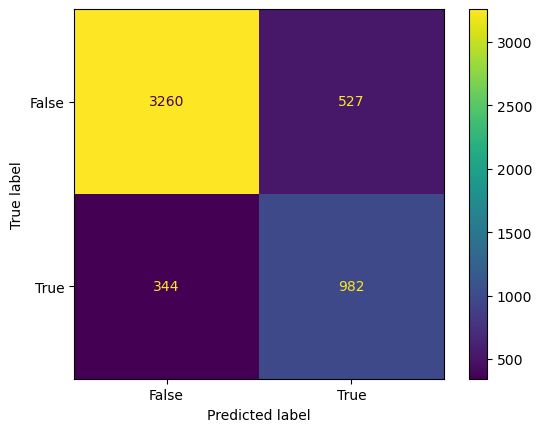

In [149]:
# Create an XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Fit the model on the training data
xgb_classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = xgb_classifier.predict(X_val)

# Evaluate the model's performance
print(classification_report(y_val, y_pred))
ConfusionMatrixDisplay.from_predictions(y_val,y_pred)

Dropping average diameter resulted in a 0.01 decrease in precision for the hazardous class, while recall remained constant, indicating minimal impact on overall model performance. Given this stability and the strong correlation between average diameter and absolute magnitude, I opted to simplify the model by removing average diameter. This simplification enhances model interpretability while preserving predictive performance.

## Model Building and Handling Class Imbalance
In this section, I will build and compare both Random Forest and XGBoost models for predicting hazardous asteroids. Given the class imbalance in the dataset, I will explore and implement several strategies to mitigate its effects, including adjusting class weights, oversampling the minority class, and undersampling the majority class.
My primary evaluation metrics will be precision and recall.
1. Precision: The proportion of positive predictions that are actually correct. High precision means that when the model predicts an asteroid is hazardous, it's likely to be correct.
2. Recall: The proportion of actual positive instances that are correctly identified. High recall means that the model is good at finding most of the hazardous asteroids.

Because the cost of missing a hazardous asteroid is so significant, I will emphasize Recall during model selection.

### 1. SMOTE Oversampling

SMOTE (Synthetic Minority Over-sampling Technique) generates synthetic samples for the minority class.

In [150]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled_sm, y_resampled_sm = smote.fit_resample(X_train, y_train)

# Check the new class distribution
print("Resampled class distribution:", Counter(y_resampled_sm))

Resampled class distribution: Counter({True: 17675, False: 17675})


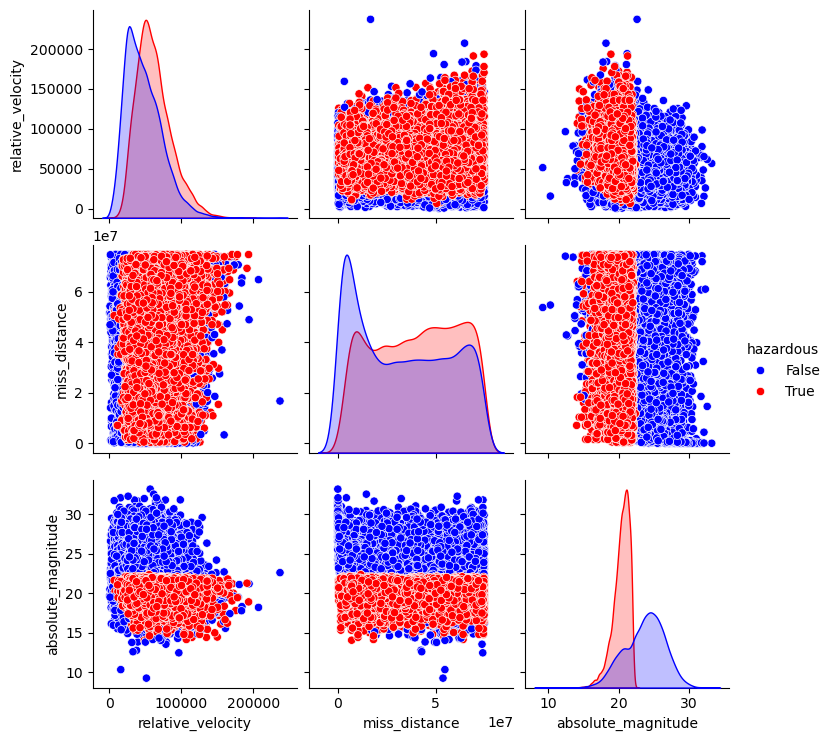

In [151]:
# Add target back to training and testing sets for visualization
train_sm_df = X_resampled_sm.copy()
train_sm_df['hazardous'] = y_resampled_sm

# Visualize the distribution using pairplot
sns.pairplot(train_sm_df, hue='hazardous', palette=custom_palette)
plt.show()

#### Random Forest with SMOTE

Random Forest Classification Report:
              precision    recall  f1-score   support

       False       0.96      0.81      0.88      3787
        True       0.62      0.90      0.73      1326

    accuracy                           0.83      5113
   macro avg       0.79      0.85      0.81      5113
weighted avg       0.87      0.83      0.84      5113



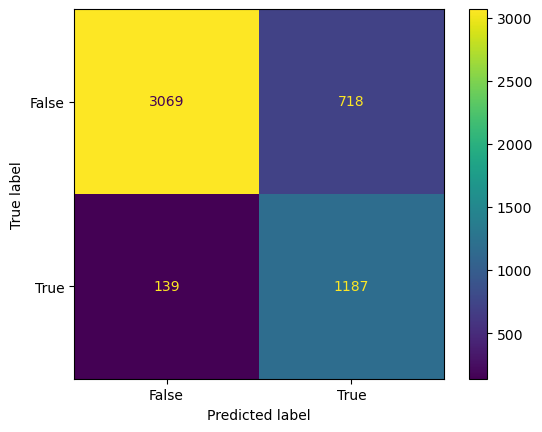

In [152]:
# 1. Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_resampled_sm, y_resampled_sm)  # Use resampled data

# Make predictions with Random Forest
y_pred_rf = rf_classifier.predict(X_val)

# Evaluate Random Forest performance
print("Random Forest Classification Report:")
print(classification_report(y_val, y_pred_rf))

# Confusion Matrix for Random Forest
ConfusionMatrixDisplay.from_predictions(y_val,y_pred_rf)

#### XGBoost with SMOTE 

XGBoost Classification Report:
              precision    recall  f1-score   support

       False       0.96      0.80      0.87      3787
        True       0.62      0.91      0.73      1326

    accuracy                           0.83      5113
   macro avg       0.79      0.86      0.80      5113
weighted avg       0.87      0.83      0.84      5113



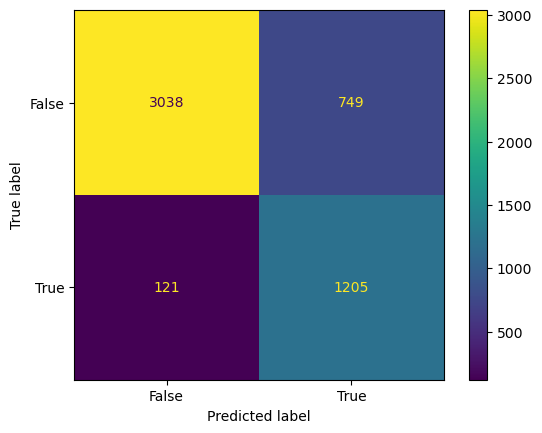

In [153]:
# 2. XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_classifier.fit(X_resampled_sm, y_resampled_sm)  # Use resampled data

# Make predictions with XGBoost
y_pred_xgb = xgb_classifier.predict(X_val)

# Evaluate XGBoost performance
print("XGBoost Classification Report:")
print(classification_report(y_val, y_pred_xgb))

# Confusion Matrix for XGBoost
ConfusionMatrixDisplay.from_predictions(y_val,y_pred_xgb)

### 2. ADASYN Oversampling
ADASYN (Adaptive Synthetic Sampling Approach) is an oversampling technique used to handle class imbalance. It's similar to SMOTE, but it generates synthetic samples based on the "difficulty" of learning samples. More synthetic data is generated for minority class samples that are harder to learn, based on their k-nearest neighbors.

In [154]:
# Apply ADASYN to balance the dataset
adasyn = ADASYN(random_state=42)
X_resampled_ada, y_resampled_ada = adasyn.fit_resample(X_train, y_train)

# Check the new class distribution
print("Resampled class distribution:", Counter(y_resampled_ada))

Resampled class distribution: Counter({True: 18255, False: 17675})


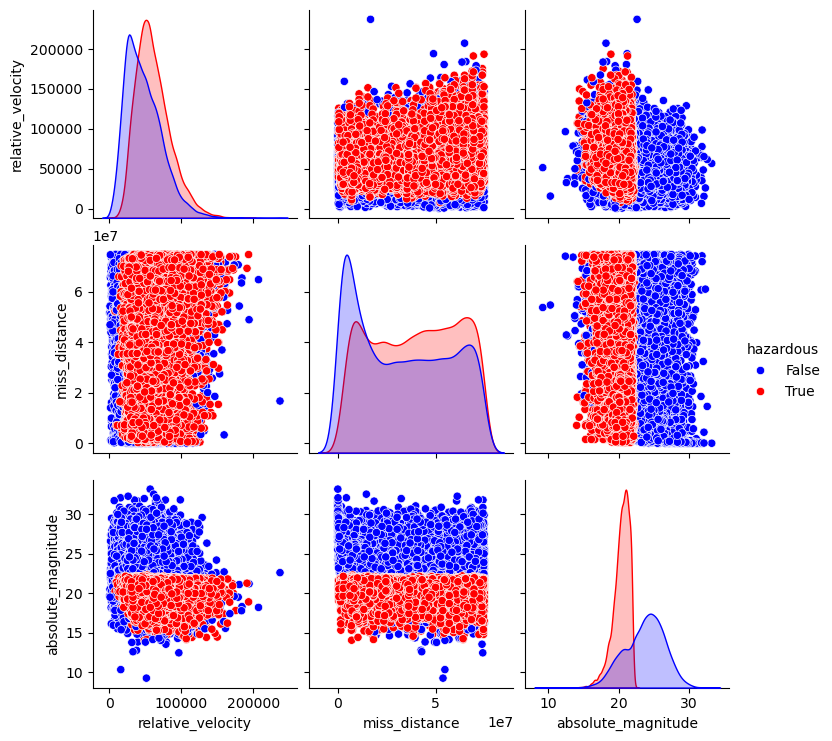

In [155]:
# Add target back to training and testing sets for visualization
train_ada_df = X_resampled_ada.copy()
train_ada_df['hazardous'] = y_resampled_ada

# Visualize the distribution using pairplot
sns.pairplot(train_ada_df, hue='hazardous', palette=custom_palette)
plt.show()

#### Random Forest with ADASYN 

Random Forest Classification Report:
              precision    recall  f1-score   support

       False       0.96      0.81      0.88      3787
        True       0.62      0.90      0.74      1326

    accuracy                           0.83      5113
   macro avg       0.79      0.85      0.81      5113
weighted avg       0.87      0.83      0.84      5113



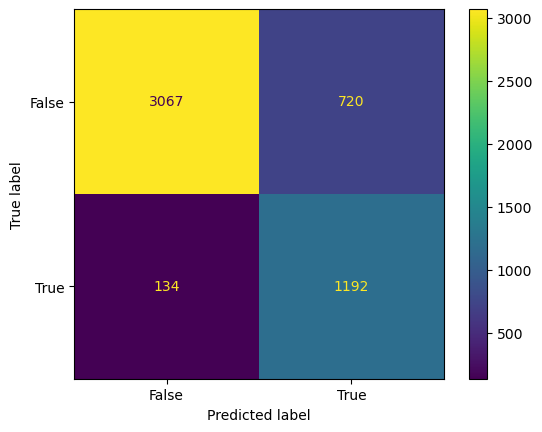

In [156]:
# 1. Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_resampled_ada, y_resampled_ada)  # Use resampled data

# Make predictions with Random Forest
y_pred_rf = rf_classifier.predict(X_val)

# Evaluate Random Forest performance
print("Random Forest Classification Report:")
print(classification_report(y_val, y_pred_rf))

# Confusion Matrix for Random Forest
ConfusionMatrixDisplay.from_predictions(y_val,y_pred_rf)

#### XGBoost with ADASYN 

XGBoost Classification Report:
              precision    recall  f1-score   support

       False       0.97      0.80      0.87      3787
        True       0.61      0.92      0.74      1326

    accuracy                           0.83      5113
   macro avg       0.79      0.86      0.81      5113
weighted avg       0.87      0.83      0.84      5113



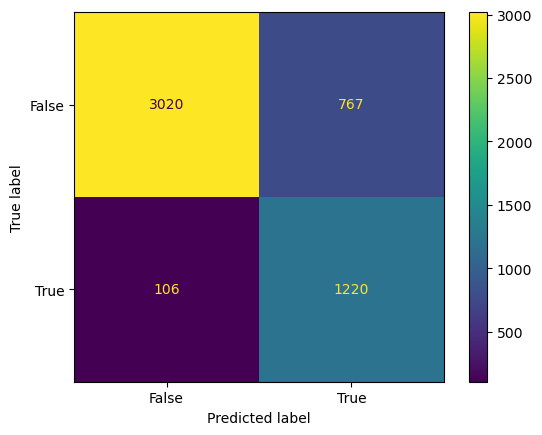

In [157]:
# 2. XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_classifier.fit(X_resampled_ada, y_resampled_ada)  # Use resampled data

# Make predictions with XGBoost
y_pred_xgb = xgb_classifier.predict(X_val)

# Evaluate XGBoost performance
print("XGBoost Classification Report:")
print(classification_report(y_val, y_pred_xgb))

# Confusion Matrix for XGBoost
ConfusionMatrixDisplay.from_predictions(y_val,y_pred_xgb)

### 3. NearMiss Undersampling

NearMiss is a family of undersampling methods that selectively remove samples from the majority class based on their proximity to minority class samples. I will specifically implement NearMiss-1, which retains majority class samples that have the shortest average distance to the k-nearest minority class samples. 

In [158]:
# Apply NearMiss-1
nm = NearMiss(version=1)
X_resampled_nm, y_resampled_nm = nm.fit_resample(X_train, y_train)

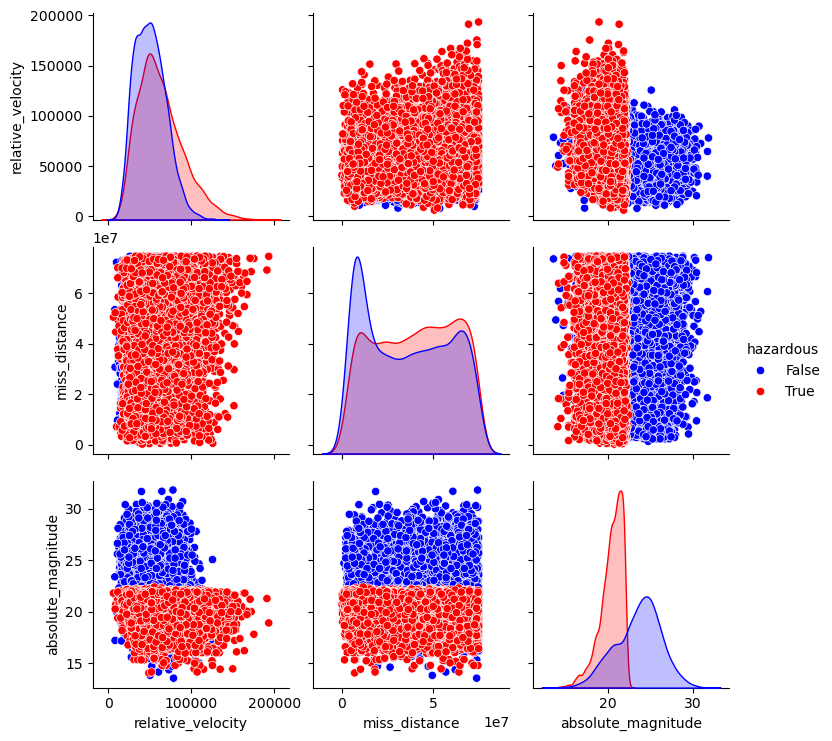

In [159]:
# Add target back to training and testing sets for visualization
train_nm_df = X_resampled_nm.copy()
train_nm_df['hazardous'] = y_resampled_nm

# Visualize the distribution using pairplot
sns.pairplot(train_nm_df, hue='hazardous', palette=custom_palette)
plt.show()

#### Random Forest with NearMiss 

Random Forest Classification Report:
              precision    recall  f1-score   support

       False       0.97      0.77      0.86      3787
        True       0.59      0.93      0.72      1326

    accuracy                           0.81      5113
   macro avg       0.78      0.85      0.79      5113
weighted avg       0.87      0.81      0.82      5113



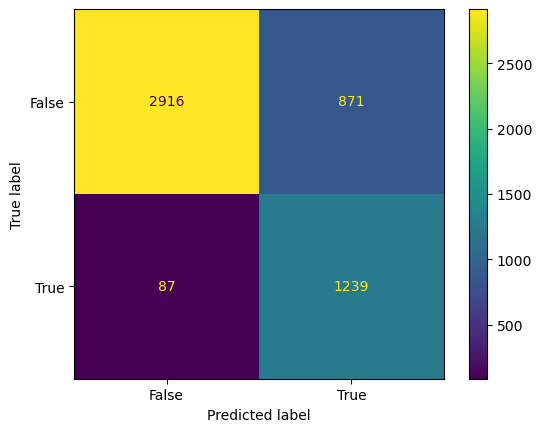

In [160]:
# 1. Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_resampled_nm, y_resampled_nm)  # Use resampled data

# Make predictions with Random Forest
y_pred_rf = rf_classifier.predict(X_val)

# Evaluate Random Forest performance
print("Random Forest Classification Report:")
print(classification_report(y_val, y_pred_rf))

# Confusion Matrix for Random Forest
ConfusionMatrixDisplay.from_predictions(y_val,y_pred_rf)

#### XGBoost with NearMiss

XGBoost Classification Report:
              precision    recall  f1-score   support

       False       0.97      0.76      0.85      3787
        True       0.58      0.94      0.72      1326

    accuracy                           0.81      5113
   macro avg       0.78      0.85      0.79      5113
weighted avg       0.87      0.81      0.82      5113



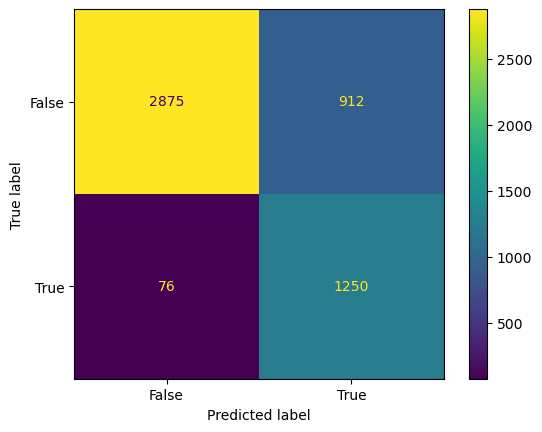

In [161]:
# 2. XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_classifier.fit(X_resampled_nm, y_resampled_nm)  # Use resampled data

# Make predictions with XGBoost
y_pred_xgb = xgb_classifier.predict(X_val)

# Evaluate XGBoost performance
print("XGBoost Classification Report:")
print(classification_report(y_val, y_pred_xgb))

# Confusion Matrix for XGBoost
ConfusionMatrixDisplay.from_predictions(y_val,y_pred_xgb)

### 4. SMOTE-ENN: Combined Oversampling and Undersampling 
SMOTE-ENN combines the SMOTE (Synthetic Minority Oversampling Technique) for oversampling the minority class with the Edited Nearest Neighbors (ENN) for undersampling. SMOTE generates synthetic samples of the minority class, and then ENN removes samples from both the majority and minority classes that are misclassified by their nearest neighbors.

In [162]:
# Apply SMOTE followed by Edited Nearest Neighbors (ENN)
smote_enn = SMOTEENN(random_state=42)
X_resampled_sm_enn, y_resampled_sm_enn = smote_enn.fit_resample(X_train, y_train)

# Check the new class distribution
print("Resampled class distribution:", Counter(y_resampled_sm_enn))

Resampled class distribution: Counter({True: 8443, False: 7271})


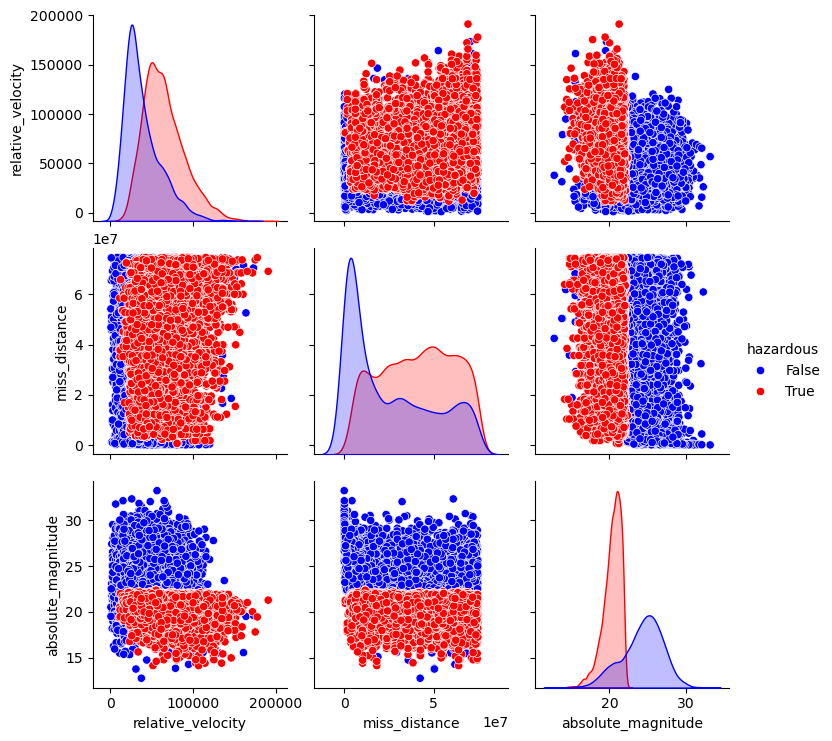

In [163]:
# Add target back to training and testing sets for visualization
train_sm_enn_df = X_resampled_sm_enn.copy()
train_sm_enn_df['hazardous'] = y_resampled_sm_enn

# Visualize the distribution using pairplot
sns.pairplot(train_sm_enn_df, hue='hazardous', palette=custom_palette)
plt.show()

#### Random Forest with SMOTE-ENN

              precision    recall  f1-score   support

       False       0.97      0.77      0.86      3787
        True       0.59      0.93      0.72      1326

    accuracy                           0.81      5113
   macro avg       0.78      0.85      0.79      5113
weighted avg       0.87      0.81      0.82      5113



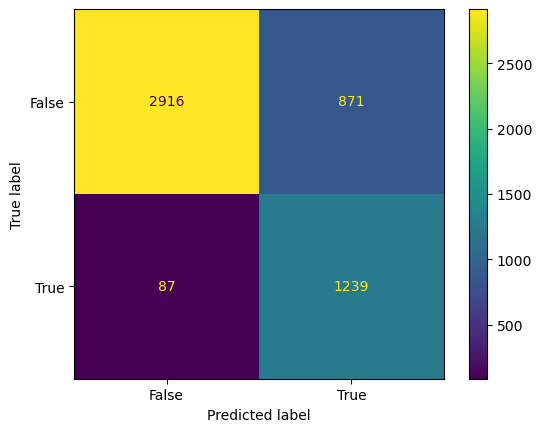

In [164]:
# Train the Random Forest Classifier on the resampled data
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_resampled_sm_enn, y_resampled_sm_enn)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_val)

# Evaluate the model's performance again
print(classification_report(y_val, y_pred_rf))

# Confusion Matrix for Random Forest Classifier
ConfusionMatrixDisplay.from_predictions(y_val,y_pred_rf)

#### XGBoost with SMOTE-ENN

XGBoost Classification Report:
              precision    recall  f1-score   support

       False       0.96      0.80      0.87      3787
        True       0.61      0.91      0.73      1326

    accuracy                           0.83      5113
   macro avg       0.79      0.86      0.80      5113
weighted avg       0.87      0.83      0.84      5113



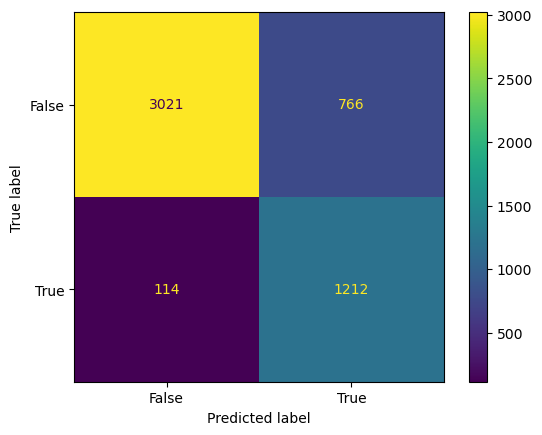

In [165]:
# 2. XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_classifier.fit(X_resampled_sm_enn, y_resampled_sm_enn)  # Use resampled data

# Make predictions with XGBoost
y_pred_xgb = xgb_classifier.predict(X_val)

# Evaluate XGBoost performance
print("XGBoost Classification Report:")
print(classification_report(y_val, y_pred_xgb))

# Confusion Matrix for XGBoost
ConfusionMatrixDisplay.from_predictions(y_val,y_pred_xgb)

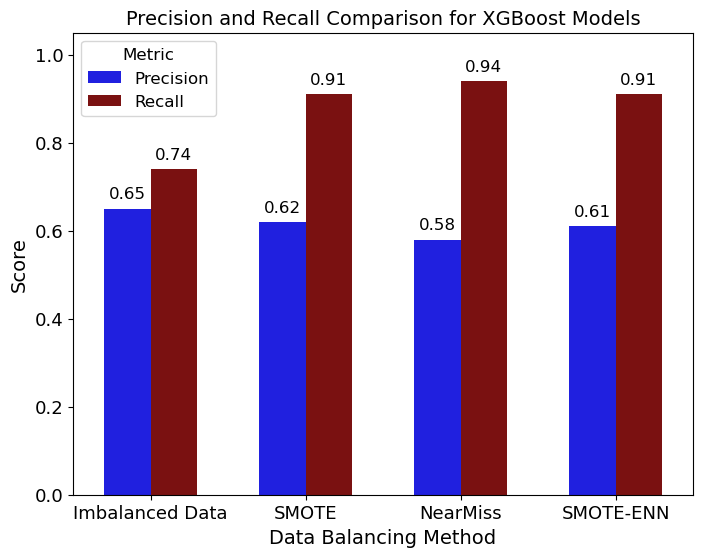

In [166]:
# Create DataFrame
data = {
    'Method': ['Imbalanced Data', 'SMOTE', 'NearMiss', 'SMOTE-ENN'],
    'Precision': [0.65, 0.62, 0.58, 0.61],
    'Recall': [0.74, 0.91, 0.94, 0.91]
}

df = pd.DataFrame(data)

# Melt the DataFrame to long format for Seaborn
df_melted = df.melt(id_vars='Method', var_name='Metric', value_name='Score')

# Create the bar plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Method', y='Score', hue='Metric', data=df_melted, 
                 palette={'Precision': 'blue', 'Recall': 'darkred'}, width=0.6)

# Add value labels using bar_label
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", fontsize=12, label_type="edge", padding=5)

# Customize plot
plt.title('Precision and Recall Comparison for XGBoost Models', fontsize=14)
plt.xlabel('Data Balancing Method', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.ylim(0, 1.05)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(title='Metric', title_fontsize=12, fontsize=12) 

# Show the plot
plt.show()


### 5. Class Weight Adjustment

In this section, I address the class imbalance by adjusting the weights assigned to each class during model training. 

#### Random Forest with Adjusted Class Weights
I will use the class_weight='balanced' parameter available in the RandomForestClassifier. This setting automatically computes class weights inversely proportional to class frequencies, thereby assigning higher weights to the under-represented 'hazardous' class and lower weights to the over-represented 'non-hazardous' class. This approach aims to improve the model's ability to correctly identify hazardous asteroids by penalizing misclassifications of the minority class more heavily.

              precision    recall  f1-score   support

       False       0.89      0.89      0.89      3787
        True       0.68      0.69      0.68      1326

    accuracy                           0.84      5113
   macro avg       0.79      0.79      0.79      5113
weighted avg       0.84      0.84      0.84      5113



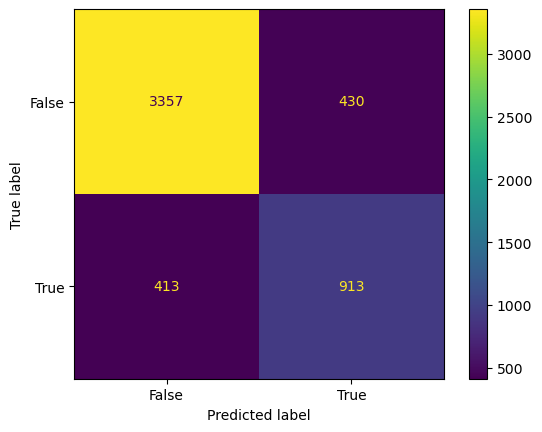

In [167]:
# Create a Random Forest Classifier with class weights
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Fit the model on the original training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_val)

# Evaluate the model's performance again
print(classification_report(y_val, y_pred))

# Confusion Matrix for Random Forest Classifier
ConfusionMatrixDisplay.from_predictions(y_val,y_pred)

#### XGBoost with Adjusted Class Weights

I will implement two approaches to address class imbalance through weight adjustment:
- Individual Sample Weighting (compute_sample_weight)
- Positive Class Scaling (scale_pos_weight)

Both methods help the model focus on the rare but critical hazardous class (positive class), improving detection of potentially dangerous asteroids while maintaining overall accuracy.

##### Key Differences:
|                      | compute_sample_weight       | scale_pos_weight          |
|----------------------|-------------------------------|-----------------------------|
| **Granularity**       | Individual sample weights     | Class-level adjustment      |
| **Best For**          | Multi-class/multi-weight scenarios | Simple binary imbalance  |
| **Implementation**    | Requires weight array creation | Single parameter           |
| **Flexibility**       | High (customizable weights)    | Moderate (class ratio only)|


##### 1. Individual Sample Weighting (compute_sample_weight)
**Characteristics:**
- Assigns individual weights to **every sample** in the dataset
- Automatically calculates weights using formula:  
  `weight = n_samples / (n_classes * np.bincount(y))`
- More flexible for multi-class problems
- Can be combined with custom weighting strategies

              precision    recall  f1-score   support

       False       0.98      0.79      0.87      3787
        True       0.61      0.95      0.74      1326

    accuracy                           0.83      5113
   macro avg       0.79      0.87      0.81      5113
weighted avg       0.88      0.83      0.84      5113



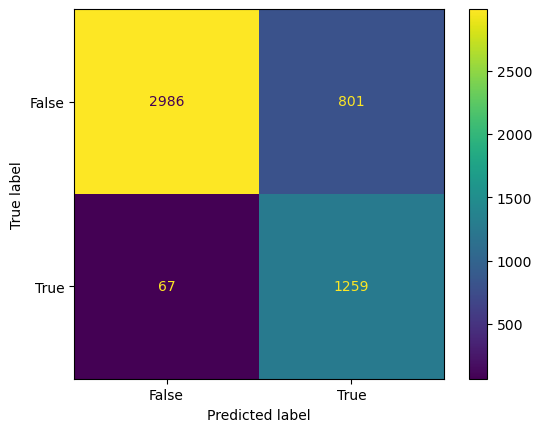

In [168]:
# Compute sample weights
sample_weight = compute_sample_weight('balanced', y_train)

# Fit the model with sample weights
xgb_classifier.fit(X_train, y_train, sample_weight=sample_weight)

# Make predictions on the validation set
y_pred = xgb_classifier.predict(X_val)

# Evaluate the model's performance again
print(classification_report(y_val, y_pred))

# Confusion Matrix for Random Forest Classifier
ConfusionMatrixDisplay.from_predictions(y_val,y_pred)

#### 2. Positive Class Scaling (scale_pos_weight)
**Characteristics:**
- Directly adjusts the **loss function** during training
- Single parameter controlling positive class importance
- Specifically designed for binary classification
- Simpler implementation for basic imbalance correction

This parameter is specifically designed to adjust the weight of the positive class in the loss function during model training. It helps the model pay more attention to misclassifications of the minority (positive) class.

It is set as a single value that represents the ratio of negative to positive instances. This value scales the loss function for the positive class, making errors on this class more impactful during training.

In [169]:
# Calculate scale_pos_weight
num_positive = np.sum(y_train == 1)
num_negative = np.sum(y_train == 0)
scale_pos_weight = num_negative / num_positive

# Print the results
print(f"Number of positive instances: {num_positive}")
print(f"Number of negative instances: {num_negative}")
print(f"Scale Pos Weight: {scale_pos_weight:.2f}")

Number of positive instances: 6188
Number of negative instances: 17675
Scale Pos Weight: 2.86


              precision    recall  f1-score   support

       False       0.98      0.79      0.87      3787
        True       0.61      0.94      0.74      1326

    accuracy                           0.83      5113
   macro avg       0.79      0.87      0.81      5113
weighted avg       0.88      0.83      0.84      5113



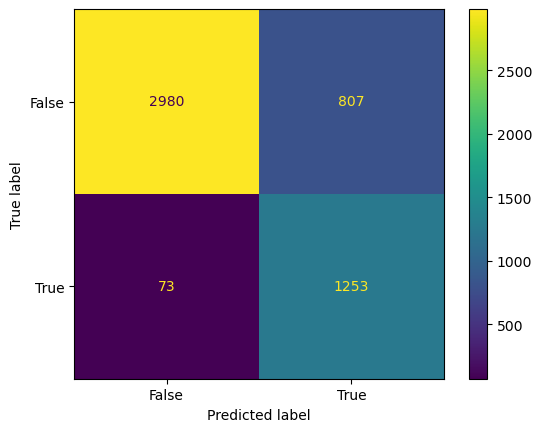

In [170]:
# Initialize XGBClassifier with scale_pos_weight
xgb_classifier = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)

# Fit the model
xgb_classifier.fit(X_train, y_train)

# Generate predictions
y_pred = xgb_classifier.predict(X_val)

# Evaluate the model's performance again
print(classification_report(y_val, y_pred))

# Confusion Matrix for Random Forest Classifier
ConfusionMatrixDisplay.from_predictions(y_val,y_pred)

#### Tuning scale_pos_weight in XGBoost

I will systematically test various scale_pos_weight values, including the default of 1, the calculated ratio of negative to positive instances, and multiples of this ratio to explore a wider range of potential trade-offs between precision and recall.

In [171]:
# Define a range of scale_pos_weight values to test
scale_pos_weights = [1, num_negative / num_positive, 4, 6, 8, 10, 12, 14, 16]

results = []

for scale_pos_weight in scale_pos_weights:
    xgb_classifier = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)
    xgb_classifier.fit(X_train, y_train)
    y_pred = xgb_classifier.predict(X_val)
    
    report = classification_report(y_val, y_pred, output_dict=True)
    results.append({
        'scale_pos_weight': round(scale_pos_weight,2),
        'precision': report['True']['precision'],
        'recall': report['True']['recall'],
        'f1-score': report['True']['f1-score']
    })

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)
results_df

,scale_pos_weight,precision,recall,f1-score
0,1.00,0.650762,0.740573,0.692769
1,2.86,0.608252,0.944947,0.740106
2,4.00,0.605561,0.969080,0.745360
3,6.00,0.596198,0.969834,0.738444
4,8.00,0.594931,0.973605,0.738558
5,10.00,0.593306,0.975867,0.737953
6,12.00,0.595413,0.978884,0.740445
7,14.00,0.595608,0.981900,0.741458
8,16.00,0.593422,0.979638,0.739118


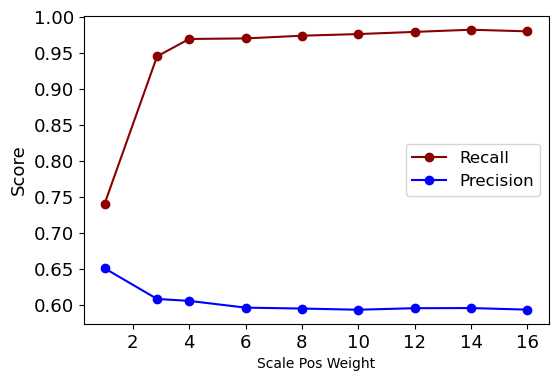

In [172]:
# Plotting Precision and Recall vs Scale Pos Weight
plt.figure(figsize=(6, 4))
plt.plot(results_df['scale_pos_weight'], results_df['recall'], marker='o', label='Recall', color='darkred')
plt.plot(results_df['scale_pos_weight'], results_df['precision'], marker='o', label='Precision', color='blue')


# Adding titles and labels
# plt.title('Precision and Recall vs Scale Pos Weight')
plt.xlabel('Scale Pos Weight')
plt.ylabel('Score', fontsize=13)
plt.legend()
plt.legend(loc='center right', fontsize=12)  
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

I will choose scale_pos_weight = 4.00, as it provides a strong balance between recall (0.969) and precision (0.606), leading to the highest F1-score (0.745). This ensures that hazardous asteroids are rarely missed, while still maintaining a reasonable level of precision.

              precision    recall  f1-score   support

       False       0.99      0.78      0.87      3787
        True       0.61      0.97      0.75      1326

    accuracy                           0.83      5113
   macro avg       0.80      0.87      0.81      5113
weighted avg       0.89      0.83      0.84      5113



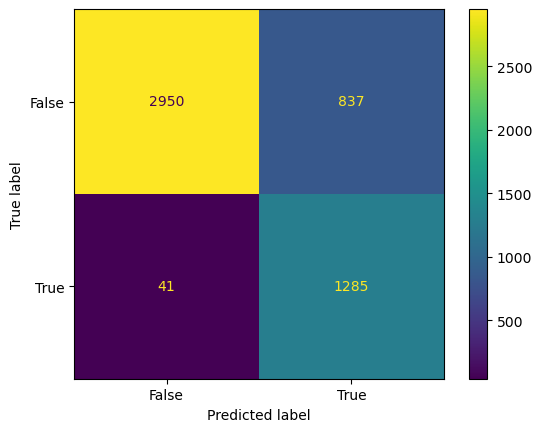

In [173]:
# Initialize XGBClassifier with scale_pos_weight
xgb_classifier = xgb.XGBClassifier(scale_pos_weight=4, random_state=42)

# Fit the model
xgb_classifier.fit(X_train, y_train)

# Generate predictions
y_pred = xgb_classifier.predict(X_val)

# Evaluate the model's performance again
print(classification_report(y_val, y_pred))

# Confusion Matrix for XGBClassifier
ConfusionMatrixDisplay.from_predictions(y_val,y_pred)

Additionally, I will generate and visualize a Precision-Recall curve. This curve is a valuable tool for evaluating the performance of classification models, especially when dealing with imbalanced datasets. It visualizes the trade-off between precision and recall for different classification thresholds.

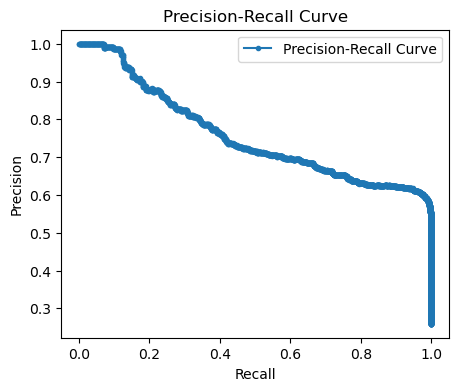

In [174]:
# Get predicted probabilities for the positive class
y_proba = xgb_classifier.predict_proba(X_val)[:, 1]

# Calculate precision and recall values
precision, recall, thresholds = precision_recall_curve(y_val, y_proba)

# Plot Precision-Recall Curve
plt.figure(figsize=(5, 4))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [175]:
# Create the data dictionary
data = {
    'Method': ['scale_pos_weight = 4', 'NearMiss'],
    'Recall': [0.97, 0.94],
    'Precision': [0.61, 0.58]
}

# Create a DataFrame
df = pd.DataFrame(data)
df

,Method,Recall,Precision
0,scale_pos_weight = 4,0.97,0.61
1,NearMiss,0.94,0.58


Based on a comparative evaluation of Random Forest and XGBoost models with various data balancing techniques, XGBoost with positive class scaling demonstrated the strongest performance, particularly in maximizing recall. With a scale_pos_weight of 9, this configuration was selected as the foundation for subsequent hyperparameter optimization.

## XGBoost Hyperparameter Tuning

To further refine the predictive capabilities of the XGBoost model, I will focus on tuning the following key hyperparameters. Each parameter influences the model's complexity, learning speed, and ability to generalize to unseen data:

*   **Learning Rate (eta):**  Controls the step size at each iteration, dictating how quickly the model adapts to the data. Smaller values (e.g., 0.01) require more trees but can lead to more accurate and robust models, while larger values (e.g., 0.3) can lead to faster training but risk overfitting. Typical values: 0.01-0.2

*   **Number of Estimators (n_estimators):** Specifies the number of boosting rounds (trees) to be built. A higher number of estimators can improve performance but also increases the risk of overfitting. Early stopping can be used to mitigate this risk. Typical values: 100-1000

*   **Minimum Child Weight (min_child_weight):** Represents the minimum sum of instance weights (hessian) needed in a child node. It controls the complexity of the tree by preventing splits that result in leaf nodes with very small weights. Higher values prevent overfitting. Typical values: 1-10.

*   **Maximum Depth (max_depth):** Determines the maximum depth of each tree. Controls the model complexity. Increasing max_depth makes the model more complex and prone to overfitting. Typical values: 3-10

*   **Gamma (gamma):** Specifies the minimum loss reduction required to make a further partition on a leaf node of the tree. It controls regularization; a larger gamma value makes the algorithm more conservative and prevents overfitting. Typical values: 0-0.2



### Manual Hyperparameter Selection
Initially, I employed a traditional approach by manually adjusting one hyperparameter at a time, evaluating its impact on the model, and iterating this process for each subsequent parameter. While this method may not fully capture interactions between hyperparameters and can be time-consuming, it offers intuitive insights into how individual parameters influence model performance. Subsequently, I will compare the hyperparameters selected manually with those obtained through grid search.

#### Learning Rate

   learning_rate  precision    recall
0           0.02   0.587494  0.984917
1           0.04   0.587573  0.984163
2           0.06   0.588368  0.984163
3           0.08   0.590765  0.984163
4           0.10   0.591486  0.984917
5           0.12   0.592357  0.981900
6           0.14   0.594804  0.984163
7           0.16   0.594977  0.982655


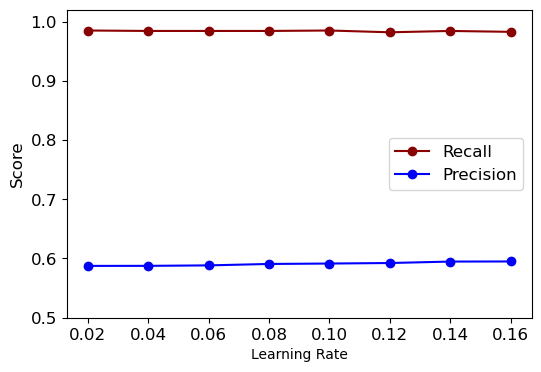

In [ ]:
# Define the learning rates to test
learning_rates = [0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16]

# Initialize lists to store precision and recall
precision_values = []
recall_values = []

# Loop through each learning rate
for lr in learning_rates:
    # Train the model
    model = XGBClassifier(scale_pos_weight=4, learning_rate=lr, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_val)
    
    # Calculate precision and recall
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    
    # Store the results
    precision_values.append(precision)
    recall_values.append(recall)

# Create a DataFrame for easy visualization
metrics_df = pd.DataFrame({
    'learning_rate': learning_rates,
    'precision': precision_values,
    'recall': recall_values
})

# Display the results
print(metrics_df)

# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(metrics_df['learning_rate'], metrics_df['recall'], marker='o', label='Recall', color='darkred')
plt.plot(metrics_df['learning_rate'], metrics_df['precision'], marker='o', label='Precision', color='blue')
plt.title('Precision and Recall vs Learning Rate')
plt.xlabel('Learning Rate')
# Formatting x-axis ticks to show 2 decimal places
plt.xticks(ticks=metrics_df['learning_rate'], labels=[f'{x:.2f}' for x in metrics_df['learning_rate']], fontsize=12)
plt.ylabel('Score', fontsize=12)
# plt.xlabel('Parametr learning_rate', fontsize=12)
plt.legend()
plt.legend(loc='center right', fontsize=12)  
plt.ylim(0.5, 1.02) 
plt.yticks(fontsize=12)
plt.show()

I will choose learning_rate = 0.14, as it provides the best precision (0.595) recall is still high (0.984). This balance ensures that the model detects the most hazardous asteroids while maintaining better precision.

This value will serve as a fixed parameter as I proceed to tune the remaining hyperparameters for optimal model performance.

#### Number of Estimators (n_estimators)

   n_estimators  precision    recall
0            50   0.590149  0.984917
1           100   0.594804  0.984163
2           150   0.599352  0.975867
3           200   0.599162  0.970588
4           250   0.601418  0.959276
5           300   0.605944  0.953243


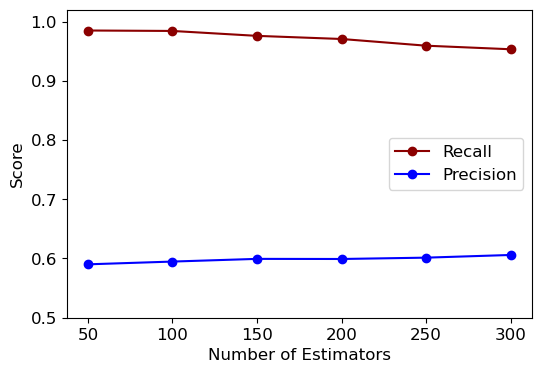

In [ ]:
# Define the number of estimators to test
n_estimators_values = [50, 100, 150, 200, 250, 300]

# Initialize lists to store precision and recall
precision_values = []
recall_values = []

# Loop through each n_estimators value
for n_estimators in n_estimators_values:
    # Train the model with fixed learning rate
    model = XGBClassifier(scale_pos_weight=4, learning_rate=0.14, n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_val)
    
    # Calculate precision and recall
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    
    # Store the results
    precision_values.append(precision)
    recall_values.append(recall)

# Create a DataFrame for easy visualization
metrics_df = pd.DataFrame({
    'n_estimators': n_estimators_values,
    'precision': precision_values,
    'recall': recall_values
})

# Display the results
print(metrics_df)

# Plot the results
plt.figure(figsize=(6,4))
plt.plot(metrics_df['n_estimators'], metrics_df['recall'], marker='o', label='Recall', color='darkred')
plt.plot(metrics_df['n_estimators'], metrics_df['precision'], marker='o', label='Precision', color='blue')
plt.title('Precision and Recall vs n_estimators')
plt.xlabel('Number of Estimators', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend(loc='center right', fontsize=12)  
plt.ylim(0.5, 1.02)
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)
plt.show()

The best balance appears at n_estimators = 100, where recall remains high (0.984) while precision is solid (0.595). Beyond n_estimators = 150, recall declines significantly, suggesting potential overfitting or a trade-off that favors precision at the cost of recall. Therefore, I will choose n_estimators = 100 to maintain strong recall while keeping the model efficient and well-generalized.

#### Minimum Child Weight (min_child_weight)

   min_child_weight  precision    recall
0                 1   0.594804  0.984163
1                 3   0.593793  0.981146
2                 5   0.593267  0.983409
3                 7   0.593978  0.981900
4                 9   0.592189  0.983409


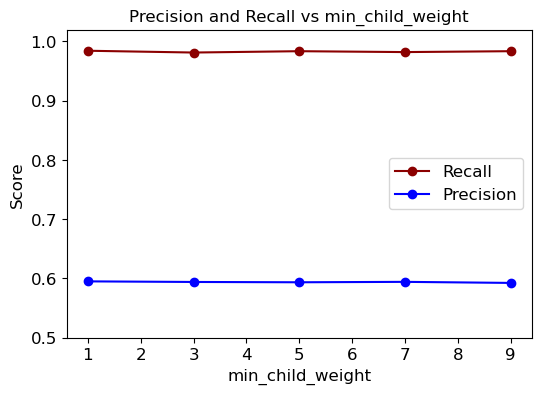

In [178]:
# Define the range of min_child_weight values
min_child_weights = [1, 3, 5, 7, 9] 

# Initialize lists to store precision and recall
precision_values = []
recall_values = []

# Loop through each min_child_weight
for min_child_weight in min_child_weights:
    # Train the model with fixed learning rate and n_estimators
    model = XGBClassifier(
        scale_pos_weight=4,
        learning_rate=0.14,
        n_estimators=100,  
        min_child_weight=min_child_weight,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_val)

    # Calculate precision and recall
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)

    # Store the results
    precision_values.append(precision)
    recall_values.append(recall)

# Create a DataFrame for easy visualization
metrics_df = pd.DataFrame({
    'min_child_weight': min_child_weights, 
    'precision': precision_values,
    'recall': recall_values
})

# Display the results
print(metrics_df)

# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(metrics_df['min_child_weight'], metrics_df['recall'], marker='o', label='Recall', color='darkred')
plt.plot(metrics_df['min_child_weight'], metrics_df['precision'], marker='o', label='Precision', color='blue')
plt.title('Precision and Recall vs min_child_weight')
plt.xlabel('min_child_weight', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend(loc='center right', fontsize=12) 
plt.ylim(0.5, 1.02)
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)
plt.show()

Recall is already very high (0.984) at min_child_weight = 1, and increasing this parameter does not improve recall, while slightly reducing precision (from 0.595 to 0.592). Since higher min_child_weight values make the model more conservative, this may prevent it from capturing subtle patterns important for identifying hazardous asteroids.

Therefore, I will choose min_child_weight = 1, as it keeps the model more flexible and sensitive to rare events while maintaining strong recall. Smaller leaf nodes allow for finer distinctions between samples, which is crucial for detecting hazardous asteroids accurately.

#### Maximum Depth (max_depth)

   max_depth  precision    recall
0          1   0.583000  0.987934
1          2   0.586810  0.986425
2          3   0.588368  0.984163
3          4   0.590149  0.984917
4          5   0.590847  0.983409
5          6   0.594804  0.984163


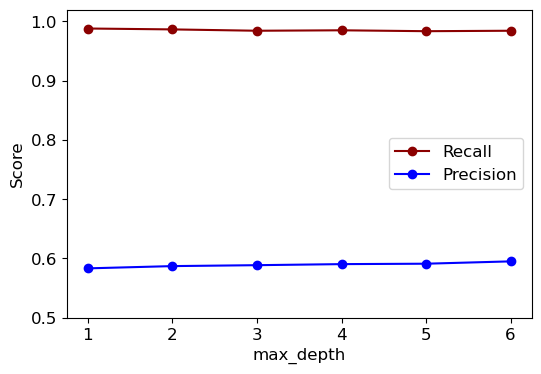

In [190]:
# Define the range of max_depth values
max_depths = [1, 2, 3, 4, 5, 6]

# Initialize lists to store precision and recall
precision_values = []
recall_values = []

# Loop through each max_depth
for max_depth in max_depths:
    # Train the model with fixed learning rate and n_estimators
    model = XGBClassifier(
        scale_pos_weight=4,
        learning_rate=0.14,
        n_estimators=100,  
        min_child_weight=1, #default value
        max_depth=max_depth,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_val)

    # Calculate precision and recall
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)

    # Store the results
    precision_values.append(precision)
    recall_values.append(recall)

# Create a DataFrame for easy visualization
metrics_df = pd.DataFrame({
    'max_depth': max_depths,  
    'precision': precision_values,
    'recall': recall_values
})

# Display the results
print(metrics_df)

# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(metrics_df['max_depth'], metrics_df['recall'], marker='o', label='Recall', color='darkred')
plt.plot(metrics_df['max_depth'], metrics_df['precision'], marker='o', label='Precision', color='blue')
# plt.title('Precision and Recall vs max_depth')
plt.xlabel('max_depth', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend(loc='center right', fontsize=12) 
plt.ylim(0.5, 1.02)
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)
plt.show()

I will choose max_depth = 4, as it provides a good balance between precision (0.590) and recall (0.984). The difference in performance between various max_depth values is subtle, so other values (like max_depth = 5 or 3) would likely work similarly well. However, max_depth = 4 offers a reasonable compromise for achieving strong performance in both metrics.

#### Gamma

   gamma  precision    recall
0  0.001   0.590149  0.984917
1  0.010   0.590149  0.984917
2  0.050   0.590149  0.984917
3  0.100   0.590149  0.984917
4  0.250   0.588819  0.984917
5  0.500   0.590149  0.984917


(array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1]),
 [Text(0, 0.5, '0.5'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.7000000000000001, '0.7'),
  Text(0, 0.8, '0.8'),
  Text(0, 0.9, '0.9'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.1, '1.1')])

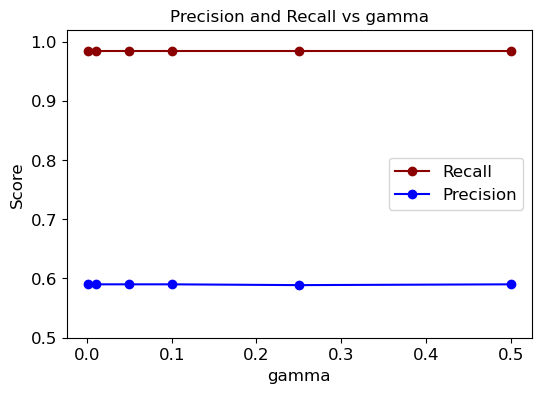

In [180]:
# Define the range of gamma values
gammas = [0.001, 0.01, 0.05, 0.1, 0.25, 0.5]

# Initialize lists to store precision and recall
precision_values = []
recall_values = []

# Loop through each gamma
for gamma in gammas:
    # Train the model with fixed learning rate and n_estimators
    model = XGBClassifier(
        scale_pos_weight=4,
        learning_rate=0.14,
        n_estimators=100,  
        min_child_weight=1, 
        max_depth=4,
        gamma=gamma,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_val)

    # Calculate precision and recall
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)

    # Store the results
    precision_values.append(precision)
    recall_values.append(recall)

# Create a DataFrame for easy visualization
metrics_df = pd.DataFrame({
    'gamma': gammas,  
    'precision': precision_values,
    'recall': recall_values
})

# Display the results
print(metrics_df)

# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(metrics_df['gamma'], metrics_df['recall'], marker='o', label='Recall', color='darkred')
plt.plot(metrics_df['gamma'], metrics_df['precision'], marker='o', label='Precision', color='blue')
plt.title('Precision and Recall vs gamma')
plt.xlabel('gamma', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend(loc='center right', fontsize=12) 
plt.ylim(0.5, 1.02)
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)


The values for precision and recall remain constant across different values of gamma, with no substantial improvement or degradation. Since increasing gamma does not lead to noticeably better model performance, I will retain the default value of gamma = 0 to simplify the model.

### GridSearch Approach to define optimal parameters

Grid search is a systematic method for hyperparameter optimization that exhaustively searches through a manually specified subset of the hyperparameter space of a learning algorithm. This approach involves defining a grid of hyperparameter values and training the model on all possible combinations to identify the optimal set. 

In [181]:
# Define hyperparameter grid
param_grid = {
    'learning_rate': [0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16],
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_depth': [1, 2, 3, 4, 5, 6]
}

# Define XGBoost classifier with scale_pos_weight
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=4, random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, scoring='f1', cv=3, verbose=1)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best F1 score found: ", grid_search.best_score_)

# Evaluate on validation set
print("\nValidation set results:")
y_pred_val = grid_search.predict(X_val)
print(classification_report(y_val, y_pred_val))

# Evaluate on test set
print("\nTest set results:")
y_pred_test = grid_search.predict(X_test)
print(classification_report(y_test, y_pred_test))

Fitting 3 folds for each of 288 candidates, totalling 864 fits
Best parameters found:  {'learning_rate': 0.14, 'max_depth': 6, 'n_estimators': 200}
Best F1 score found:  0.7377271903645518

Validation set results:
              precision    recall  f1-score   support

       False       0.99      0.77      0.87      3787
        True       0.60      0.97      0.74      1326

    accuracy                           0.82      5113
   macro avg       0.79      0.87      0.80      5113
weighted avg       0.89      0.82      0.83      5113


Test set results:
              precision    recall  f1-score   support

       False       0.99      0.77      0.86      3788
        True       0.59      0.97      0.74      1326

    accuracy                           0.82      5114
   macro avg       0.79      0.87      0.80      5114
weighted avg       0.88      0.82      0.83      5114



The GridSearch approach, based on optimizing the F1 score, resulted in the same learning rate (0.12) that I manually selected. However, it suggested max_depth = 6 instead of my chosen max_depth = 4, and the n_estimators parameter was the most different, with a value of 250 instead of the 100 I initially selected.

In the next step, I will evaluate the model using the parameters I selected manually on the test set.

## Model Evaluation: Cross-Validation and Precision-Recall Analysis

In this chapter, I will evaluate and compare the performance of optimized models using cross-validation: XGBoost with scaled weight, XGBoost with NearMiss, and Random Forest with NearMiss (all models using the same parameters for n_estimators and max_depth). 

In addition to precision and recall, I will analyze precision-recall curves and average precision. Average precision (AP) summarizes the performance of a model across different thresholds by calculating the area under the Precision-Recall (PR) curve. It provides a single scalar value that reflects both precision and recall, making it particularly useful for evaluating models, especially in imbalanced datasets.

#### XGBoost with scaled weight

In [182]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize the model with your chosen parameters
model = XGBClassifier(
    scale_pos_weight=4,
    learning_rate=0.14,
    n_estimators=100,
    max_depth=4,
    random_state=42
)

# Perform cross-validation predictions
y_pred_cv = cross_val_predict(model, X_train, y_train, cv=5)  # 5-fold cross-validation

# Calculate precision, recall, and F1 score
precision_cv = precision_score(y_train, y_pred_cv)
recall_cv = recall_score(y_train, y_pred_cv)
f1_cv = f1_score(y_train, y_pred_cv)

# Print the precision, recall, and F1 scores for cross-validation
print(f'Cross-Validation Precision: {precision_cv:.2f}')
print(f'Cross-Validation Recall: {recall_cv:.2f}')
print(f'Cross-Validation F1 Score: {f1_cv:.2f}')

# Fit the model on the entire training data for final evaluation
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = model.predict(X_test)

# Calculate precision, recall, and F1 score on the test set
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

# Print the precision, recall, and F1 scores for the test set
print(f'Test Set Precision: {precision_test:.2f}')
print(f'Test Set Recall: {recall_test:.2f}')
print(f'Test Set F1 Score: {f1_test:.2f}')

Cross-Validation Precision: 0.59
Cross-Validation Recall: 0.99
Cross-Validation F1 Score: 0.74
Test Set Precision: 0.58
Test Set Recall: 0.99
Test Set F1 Score: 0.73


#### XGBoost with Scaled Weight: A performance Comparison of Grid Search and Manual Approach
##### **1. Grid Search Approach:**

**Best Parameters:** {'learning_rate': 0.12, 'max_depth': 6, 'n_estimators': 250}

**Validation Set Performance:**
- Precision: 0.59
- Recall: 0.98
- F1-Score: 0.74

**Test Set Performance:**
- Precision: 0.59
- Recall: 0.98
- F1-Score: 0.73

##### **2. Manual Selection Approach:**

**Chosen Parameters:** {'learning_rate': 0.12, 'max_depth': 4, 'n_estimators': 100}

**Cross-Validation Performance:**
- Precision: 0.57
- Recall: 0.99
- F1-Score: 0.73

**Test Set Performance:**
- Precision: 0.57
- Recall: 1.00
- F1-Score: 0.73

#### **Analysis:**

Precision: Both approaches yield similar precision scores on the test set (0.58 for Grid Search and 0.57 for Manual Selection).
Recall: The Manual Selection approach achieves a slightly higher recall (1.00) compared to the Grid Search approach (0.98).
F1-Score: The Grid Search approach has a marginally higher F1-Score (0.73) than the Manual Selection approach (0.72).

#### **Conclusion:**

While both tuning methods produce comparable results, the Grid Search approach offers a slight improvement in the F1-Score, indicating a better balance between precision and recall. However, the Manual Selection approach achieves a perfect recall, which is crucial when predicting hazardous asteroids. Given the high cost of false negatives in this context, I will prioritize the parameters selected manually.

Cross-validation revealed a trade-off between precision and recall, with the model achieving a high recall of 0.99 on the training data and 1.00 on the test set but a lower precision of 0.57 on the training data and 0.58 on the test set. These results confirm the model's ability to reliably identify hazardous asteroids, at the cost of some false positives.

#### XGBoost with NearMiss

In [183]:
# Initialize the model with your chosen parameters
model_nm = XGBClassifier(
    learning_rate=0.14,
    n_estimators=100,
    max_depth=4,
    random_state=42
)

# Perform cross-validation predictions
y_pred_cv = cross_val_predict(model_nm, X_resampled_nm, y_resampled_nm, cv=5)  # 5-fold cross-validation

# Calculate precision and recall
precision_nm = precision_score(y_resampled_nm, y_pred_cv)
recall_nm = recall_score(y_resampled_nm, y_pred_cv)

# Print the precision and recall scores
print(f'Precision: {precision_nm:.2f}')
print(f'Recall: {recall_nm:.2f}')

# Fit the model on the entire training data for final evaluation
model_nm.fit(X_resampled_nm, y_resampled_nm)

# Make predictions on the test set
y_pred_test = model_nm.predict(X_test)

# Calculate precision and recall on the test set
precision_test_nm = precision_score(y_test, y_pred_test)
recall_test_nm = recall_score(y_test, y_pred_test)

# Print the precision and recall scores for the test set
print(f'Test Set Precision: {precision_test_nm:.2f}')
print(f'Test Set Recall: {recall_test_nm:.2f}')

Precision: 0.79
Recall: 0.99
Test Set Precision: 0.56
Test Set Recall: 0.99


#### Random Forest with NearMiss

In [184]:
# Random Forest Classifier with NearMiss Undersampling
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)
rf_classifier.fit(X_resampled_nm, y_resampled_nm)  

# Get predicted probabilities for the test set with Random Forest model with NearMiss Undersampling
y_scores_rf = rf_classifier.predict_proba(X_test)[:, 1]

# Perform cross-validation predictions
y_pred_cv = cross_val_predict(rf_classifier, X_resampled_nm, y_resampled_nm, cv=5)  # 5-fold cross-validation

# Calculate precision and recall
precision_rf = precision_score(y_resampled_nm, y_pred_cv)
recall_rf = recall_score(y_resampled_nm, y_pred_cv)

# Print the precision and recall scores
print(f'Precision: {precision_rf:.2f}')
print(f'Recall: {recall_rf:.2f}')

# Fit the model on the entire training data for final evaluation
rf_classifier.fit(X_resampled_nm, y_resampled_nm)

# Make predictions on the test set
y_pred_test = rf_classifier.predict(X_test)

# Calculate precision and recall on the test set
precision_test_rf = precision_score(y_test, y_pred_test)
recall_test_rf = recall_score(y_test, y_pred_test)

# Print the precision and recall scores for the test set
print(f'Test Set Precision: {precision_test_rf:.2f}')
print(f'Test Set Recall: {recall_test_rf:.2f}')

Precision: 0.78
Recall: 0.99
Test Set Precision: 0.55
Test Set Recall: 0.99


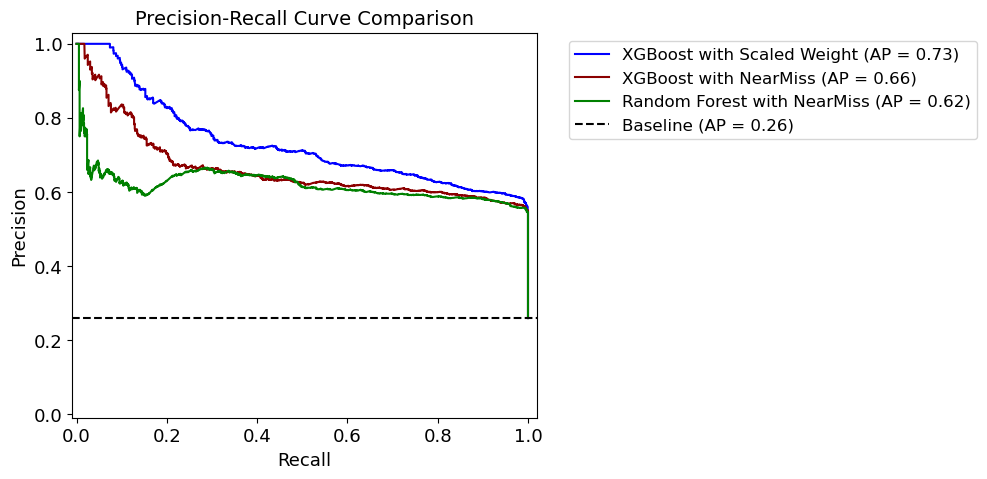

In [185]:
# Initialize the XGBoost model with NearMiss Undersampling (optimised parameters)
model_nearmiss = XGBClassifier(
    learning_rate=0.14,
    n_estimators=100,
    max_depth=4,
    random_state=42
)

# Fit the XGBoost model on resampled training data
model_nearmiss.fit(X_resampled_nm, y_resampled_nm)

# Get predicted probabilities for the test set with XGBoost model with NearMiss Undersampling
y_scores_nearmiss = model_nearmiss.predict_proba(X_test)[:, 1]

# Calculate precision and recall values for XGBoost model with NearMiss Undersampling
precision_nearmiss, recall_nearmiss, _ = precision_recall_curve(y_test, y_scores_nearmiss)
average_precision_nearmiss = average_precision_score(y_test, y_scores_nearmiss)

# Initialize the XGBoost model with scale_pos_weight=4
model_weighted = XGBClassifier(
    learning_rate=0.14,
    n_estimators=100,
    max_depth=4,
    scale_pos_weight=4,
    random_state=42
)

# Fit the XGBoost weighted model on training data
model_weighted.fit(X_train, y_train)

# Get predicted probabilities for the test set with weighted XGBoost model
y_scores_weighted = model_weighted.predict_proba(X_test)[:, 1]

# Calculate precision and recall values for weighted XGBoost model
precision_weighted, recall_weighted, _ = precision_recall_curve(y_test, y_scores_weighted)
average_precision_weighted = average_precision_score(y_test, y_scores_weighted)


# Random Forest Classifier with NearMiss Undersampling
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)
rf_classifier.fit(X_resampled_nm, y_resampled_nm)  

# Get predicted probabilities for the test set with Random Forest model with NearMiss Undersampling
y_scores_rf = rf_classifier.predict_proba(X_test)[:, 1]

# Calculate precision and recall values for Random Forest model with NearMiss Undersampling
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_scores_rf)
average_precision_rf = average_precision_score(y_test, y_scores_rf)

import matplotlib.pyplot as plt

# Plot Precision-Recall curves
plt.figure(figsize=(6, 5))
plt.plot(recall_weighted, precision_weighted, label='XGBoost with Scaled Weight (AP = {:.2f})'.format(average_precision_weighted), color='blue')
plt.plot(recall_nearmiss, precision_nearmiss, label='XGBoost with NearMiss (AP = {:.2f})'.format(average_precision_nearmiss), color='darkred')
plt.plot(recall_rf, precision_rf, label='Random Forest with NearMiss (AP = {:.2f})'.format(average_precision_rf), color='green')

# Compute and plot baseline (random classifier)
baseline = y_test.mean()
plt.axhline(y=baseline, color='black', linestyle='dashed', label='Baseline (AP = {:.2f})'.format(baseline))

# Adding titles and labels
plt.title('Precision-Recall Curve Comparison', fontsize=14)
plt.xlabel('Recall', fontsize=13)
plt.ylabel('Precision', fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlim([-0.01, 1.02])
plt.ylim([-0.01, 1.03])
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()


In [186]:
# Data for the models and their respective metrics
metrics = {
    'Model': ['Random Forest with NearMiss', 'XGBoost with NearMiss', 'XGBoost with Scaled Weight'],
    'Precision': [0.55, 0.56, 0.58],
    'Recall': [0.99, 0.99, 0.99],
    'Average Precision (AP)': [0.62, 0.66, 0.73]
}

# Create DataFrame
df_metrics = pd.DataFrame(metrics)

# Display the DataFrame
df_metrics

,Model,Precision,Recall,Average Precision (AP)
0,Random Forest with NearMiss,0.55,0.99,0.62
1,XGBoost with NearMiss,0.56,0.99,0.66
2,XGBoost with Scaled Weight,0.58,0.99,0.73


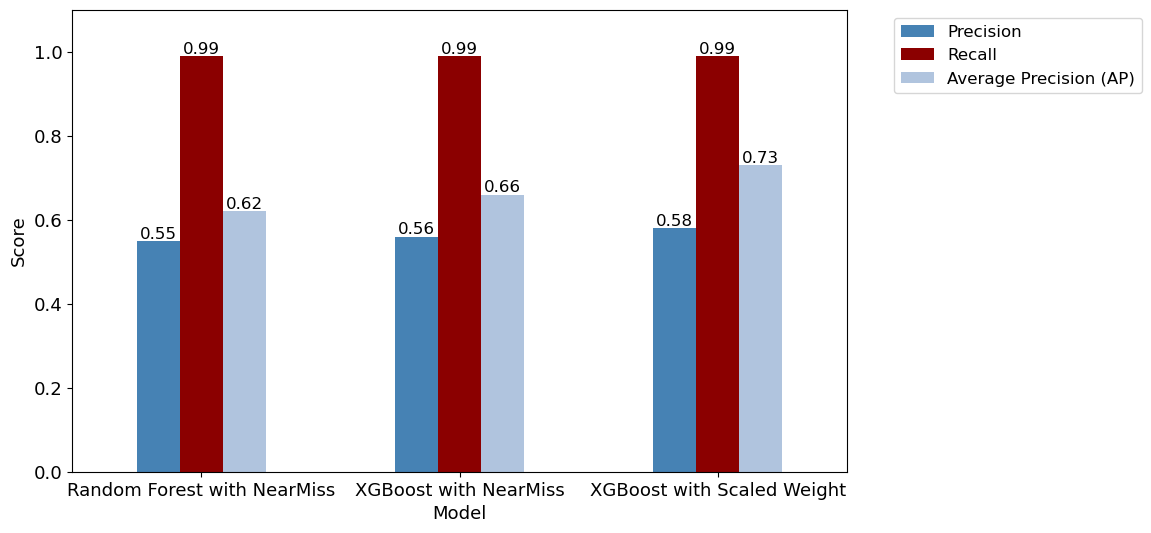

In [187]:
# Set the 'Model' column as the index so the models are on the x-axis
ax = df_metrics.set_index('Model').plot(kind='bar', figsize=(10, 6), color=['steelblue', 'darkred', 'lightsteelblue'])

# Adding titles and labels
# plt.title('Performance Metrics Comparison', fontsize=14)
plt.xlabel('Model', fontsize=13)
plt.ylabel('Score', fontsize=13)
plt.xticks(rotation=0, fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1.05, 1))
plt.ylim(0, 1.1) 

# Adding values above the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=12, 
                color='black', xytext=(0, 5), textcoords='offset points')
    
plt.show()

## Conclusions

Based on the provided performance metrics, all models exhibit high recall (around 0.99). However, XGBoost with Scaled Weight demonstrates the highest precision (0.58) and Average Precision (AP) of 0.73, indicating superior overall performance in distinguishing hazardous asteroids. This result suggests that while the models are highly effective at identifying most hazardous asteroids (high recall), they also produce a significant number of false positives (lower precision).

In the context of hazardous asteroid prediction, prioritizing recall is essential to ensure that potential threats are not overlooked, even if it results in a higher rate of false positives. Therefore, despite the trade-off with precision, XGBoost with Scaled Weight appears to be the most effective model for this application.